In [1335]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from tqdm.auto import tqdm 
import matplotlib.gridspec as gridspec
# from factanal.wrapper import factanal
import json
import seaborn as sns

import geopandas as gp
# import geoplot

# import geoplot.crs as gcrs

from scipy import signal
from sklearn.decomposition import FastICA, PCA

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



from sklearn.decomposition import non_negative_factorization, NMF

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [1336]:
from factor_analyzer import FactorAnalyzer, ConfirmatoryFactorAnalyzer, ModelSpecificationParser
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [1337]:
def scree_plot(ev,df):    
    plt.plot(range(1,df.shape[1]+1),ev,'-o',color='b')
    plt.title('Scree Plot')
    plt.xlabel('Number of factors')
    plt.ylabel('Eigenvalue')
    plt.axhline(y=1,c='r')
    plt.show();
       
def perform_fa(df, NUM, rotation, method):
    
#     fa = factanal(df, factors=NUM, scores='regression', rotation=rotation, 
#                   verbose=True, return_dict=True)
    
    fa = FactorAnalyzer(n_factors=NUM, rotation=rotation, method=method) 
    fa.fit(df)
    return fa


def loadings_plot(Loadings, col_names):
    fig, ax = plt.subplots(figsize=(8,8))
    c = ax.pcolor(abs(Loadings))
    fig.colorbar(c, ax=ax)
    ax.set_yticks(np.arange(Loadings.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(Loadings.shape[1])+0.5, minor=False)
    ax.set_yticklabels(col_names)
    ax.set_xticklabels(['Factor '+str(i+1) for i in range(Loadings.shape[1])])
    # plt.savefig("/home/idit/Documents/saved_data_from_notebooks/loadings_4_factors.png", dpi=500)
    plt.show();   
    
def plot_map(gdf,stations): 
    plt.ion
    # change the Coordinate Reference System (CRS)
    gdf['geometry']=gdf['geometry'].to_crs({'init':'epsg:4326'})
    df = gp.GeoDataFrame(stations, crs = {'init':'epsg:4326'}, geometry = gp.points_from_xy(stations['Lon'],stations['Lat'])) #where df is your df with the scatter data
    ax = gdf.plot(figsize=(10, 10),color='w',edgecolor='k')
    print(stations['factor'].unique())
    df.plot(ax=ax,c=stations['factor'])
    # plt.savefig("/home/idit/Documents/saved_data_from_notebooks/map_4_factors.png", dpi=500)
    for k, v in df.iterrows():
#         ax.annotate(np.round(v.max_load,2),(v.Lon,v.Lat),size=6)
        ax.annotate(v.name,(v.Lon,v.Lat),size=6)
    plt.show();
    
      
def plot_factors_and_loadings(df_scores,df_load, list_of_factors, station_names, weekend_removed):
    mpl.style.use('seaborn-white')
#     cm = ['c','m','#d9534f','#9ad801']
    cm = sns.color_palette(None, len(list_of_factors))
    
    # https://nextjournal.com/bebi5009/matplotlib-tutorial
    fig = plt.figure(figsize=(12,11))
    grid = plt.GridSpec(3, 4)  # 2 rows 3 cols
    ax1 = plt.subplot(grid[0,:3])  # top left
    df_scores.groupby(['Day in year'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax1,legend=False)
    # ax1.legend(loc='upper right')
    plt.xlim([-1,368])
    plt.xticks(np.linspace(15,365-15,12), ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'))
    plt.xlabel('\nDay in the year')

    ax2 = plt.subplot(grid[1,:3])   # middle left
    df_scores.groupby(['week day','hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax2,legend=False)

    if weekend_removed:
        # If friday and saturday were removed
        plt.xlim([-1,48*5+1])
        plt.xticks(np.linspace(24,48*5-24,5), ('Sun', 'Mon','Tue','Wed','Thu'))
    else:    
        plt.xlim([-1,48*7+1])
        plt.xticks(np.linspace(24,48*7-24,7), ('Sun', 'Mon','Tue','Wed','Thu','Fri','Sat'))

    plt.xlabel('\nHour in the week')


    ax3 = plt.subplot(grid[2,:3])  # bottom left

    df_scores.groupby(['hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax3,legend=False)
    plt.xlim([0,47])
    plt.xticks(np.linspace(1,48-1,24), [str(i) for i in range(24)])
    plt.xlabel('\nHour in the day')


    ax4 = plt.subplot(grid[0:3,3:5])  # all right

    df_load[list_of_factors].plot(kind='barh', stacked=True, color=cm,ax=ax4,legend=True)
    ax4.legend(bbox_to_anchor=(1.53, 1), loc=2 ,frameon=True)
    ax4.set_yticks(np.arange(0,len(station_names)))
    ax4.set_yticklabels(station_names)
    ax4.yaxis.tick_right()
    ax4.set_facecolor('white')
    plt.xlabel('\nLoadings')
    # plt.show();

    fig.tight_layout()
    plt.show();
    
    
def test_if_FA_suitable(df):
    
    # Bartlett’s Test - p-value should be significant
    chi_square_value,p_value=calculate_bartlett_sphericity(df)
    # Kaiser-Meyer-Olkin (KMO) Test - between 0 and 1 - when 1 is highly suitable for factor analysis
    kmo_all,kmo_model=calculate_kmo(df)
    return p_value, kmo_model
    
    
def add_group_columns_to_df_scores(df_scores,times):
    df_scores['datetime'] = pd.to_datetime(times['time'], format='%Y-%m-%d %H:%M')
    df_scores['month'] = pd.to_datetime(times['time']).dt.month
    df_scores['hour'] = pd.to_datetime(times['time']).dt.hour
    df_scores['minute'] = pd.to_datetime(times['time']).dt.minute
    df_scores['Day in year'] = pd.to_datetime(times['time']).dt.dayofyear
  
    df_scores['week day'] = pd.to_datetime(times['time']).dt.dayofweek+1
    print(df_scores['week day'].unique())
    df_scores.loc[df_scores['week day']==7,'week day']=0
    print(df_scores['week day'].unique())
    
    return df_scores

def plot_time_series_sections(df,list_of_factors,times,weekend_removed):
    
    df = add_group_columns_to_df_scores(df,times)
    cm = sns.color_palette(None, len(list_of_factors))
    
    mpl.style.use('seaborn-white')
    # https://nextjournal.com/bebi5009/matplotlib-tutorial
    fig = plt.figure(figsize=(12,11))
    grid = plt.GridSpec(3, 1)  # 2 rows 3 cols
    ax1 = plt.subplot(grid[0,:1])  # top left
    df.groupby(['Day in year'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax1,legend=False)
    # ax1.legend(loc='upper right')
    plt.xlim([-1,368])
    plt.xticks(np.linspace(15,365-15,12), ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'))
    plt.xlabel('\nDay in the year')
    ax1.legend(bbox_to_anchor=(1.1, 1), loc=2 ,frameon=True)

    ax2 = plt.subplot(grid[1,:1])   # middle left
    df.groupby(['week day','hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax2,legend=False)
    
    
    if weekend_removed:
        # If friday and saturday were removed
        plt.xlim([-1,48*5+1])
        plt.xticks(np.linspace(24,48*5-24,5), ('Sun', 'Mon','Tue','Wed','Thu'))
    else:    
        plt.xlim([-1,48*7+1])
        plt.xticks(np.linspace(24,48*7-24,7), ('Sun', 'Mon','Tue','Wed','Thu','Fri','Sat'))

    plt.xlabel('\nHour in the week')

    ax3 = plt.subplot(grid[2,:1])  # bottom left
    df.groupby(['hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax3,legend=False)
    plt.xlim([0,47])
    plt.xticks(np.linspace(1,48-1,24), [str(i) for i in range(24)])
    plt.xlabel('\nHour in the day')

    fig.tight_layout()
    plt.show();
    
    
    
def get_FA_results(df, times, NUM, rotation, stations, gdf, weekend_removed, STATIONS_TO_DROP, show_factors):

    mpl.style.use('default')
    print(test_if_FA_suitable(df))
    
    # scree plot
    fa = FactorAnalyzer()
    fa.fit(df)
    ev, _ = fa.get_eigenvalues()
    scree_plot(ev,df)
    
    df.drop(STATIONS_TO_DROP,axis=1,inplace=True)
    
    # FA
    fa = perform_fa(df, NUM, rotation, method = 'ml')
    
#     # print cummulative variance
#     print(fa.get_factor_variance())

    # print uniqueneses
    print(fa['uniquenesses'])
    
    # plot loadings 
#     # with factorAnalyzer()
#     Loadings = fa.loadings_
#     scores = fa.transform(df) # numerical value, no units

    # with factanal (R)
    Loadings = np.array(fa['loadings'])
    scores = np.array(fa['scores']) # numerical value, no units
    
    col_names = df.columns
    loadings_plot(Loadings, col_names)
    
    # plot stations  
    # ascribe a factor to each station based on max loading value (and show it on map)
    stations = stations[stations.name.isin(df.columns)]
    stations['factor'] = np.argmax(abs(Loadings),axis=1)+1
    stations['max_load'] = np.max(abs(Loadings),axis=1)
    plot_map(gdf,stations)
    
    # plot factors and loadings 
    FACTOR_COLUMNS = ['F'+str(i+1) for i in range(NUM)]
    
    if (show_factors == 'all'): 
        list_of_factors = FACTOR_COLUMNS      
        print('Hi')
    else:
        list_of_factors = show_factors
        
    
    df_load = pd.DataFrame(Loadings,columns=FACTOR_COLUMNS)
    df_scores = pd.DataFrame(scores, columns=FACTOR_COLUMNS)
#     print(df_scores.index)
#     print(times.index)
    df_scores = add_group_columns_to_df_scores(df_scores,times)
#     print(df_scores.head())
#     print(df_scores['week day'].unique())

    plot_factors_and_loadings(df_scores,df_load, list_of_factors, df.columns, weekend_removed=weekend_removed)
    
    return Loadings, scores, stations.name



In [1338]:
def initialize():
#     df = pd.read_csv("~/Documents/saved_data_from_notebooks/RF_add1_fixed_2012_2019.csv")
#     times = pd.read_csv("~/Documents/saved_data_from_notebooks/times_df_2012_2019.csv")
    times = pd.read_csv("/Users/iditbela/Documents/Broday/sent_from_Yuval/Mon_DataBase/times_df_2012_2019.csv")
    df = pd.read_csv("/Users/iditbela/Documents/Broday/sent_from_Yuval/Mon_DataBase/RF_add1_fixed_2012_2019.csv")
    
    df.drop(columns = 'Unnamed: 0',inplace=True)
    times.drop(columns = 'Unnamed: 0',inplace=True)
    times.rename({'0': 'time'}, axis = 'columns',inplace=True)
    
    # NOTE THIS STATION FILE WAS GENERATED FOR 34 STATIONS OF 2013-2018
#     stations = pd.read_csv("~/Documents/saved_data_from_notebooks/stations_info.csv") 
#     gdf = gp.read_file("/home/idit/Documents/saved_data_from_notebooks/IsraelBorder.shp")
    stations = pd.read_csv("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/stations_info.csv") 
    gdf = gp.read_file("/Users/iditbela/Documents/Broday/GIS/IsraelBorder/IsraelBorder.shp")

    return df,times,stations,gdf

# Build ONE MEGA DATABASE 2012-2019

In [1339]:
def extract_to_pickle(dictionary, path, name):   
    data = dictionary['DATA'].T
    columns = dictionary['StNames']

    col_list = []
    for c in columns:
        col_list.append(c[0][0])
        
    # first two rows are lat lon
    pd.DataFrame(data[2:,:], columns=col_list).to_pickle(path+name)
    
    
# why is the last row always nan??
def initialize_time_series(path, start_year):

    # 2018
#     times = pd.date_range(start='2000-01-01 00:00:00', end='2018-12-31 23:30:00', freq='30Min') 
    # 2019
    times = pd.date_range(start='2000-01-01 00:00:00', end='2019-12-31 23:30:00', freq='30Min') 

    start_idx = np.argwhere(times == start_year+'-01-01 00:00:00')[0][0]
       
    PM25 = pd.read_pickle(path+"PM25") #Lab's computer
    print(PM25.iloc[-1,:].isnull().sum() == PM25.shape[1])
    PM25 = PM25[start_idx:]
    PM25.reset_index(inplace=True,drop=True)
         
    PM10 = pd.read_pickle(path+"PM10") #Lab's computer
    print(PM10.iloc[-1,:].isnull().sum() == PM10.shape[1])
    PM10 = PM10[start_idx:]
    PM10.reset_index(inplace=True,drop=True)
    
    O3 = pd.read_pickle(path+"O3") #Lab's computer
    print(O3.iloc[-1,:].isnull().sum() == O3.shape[1])
    O3 = O3[start_idx:]
    O3.reset_index(inplace=True,drop=True)
    
    NO = pd.read_pickle(path+"NO") #Lab's computer
    print(NO.iloc[-1,:].isnull().sum() == NO.shape[1])
    NO = NO[start_idx:]
    NO.reset_index(inplace=True,drop=True)
    
    NO2 = pd.read_pickle(path+"NO2") #Lab's computer
    print(NO2.iloc[-1,:].isnull().sum() == NO2.shape[1])
    NO2 = NO2[start_idx:]
    NO2.reset_index(inplace=True,drop=True)
    
    NOx = pd.read_pickle(path+"NOx") #Lab's computer
    print(NOx.iloc[-1,:].isnull().sum() == NOx.shape[1])
    NOx = NOx[start_idx:]
    NOx.reset_index(inplace=True,drop=True)
  
    #absent for 2019:
#     NH3 = pd.read_pickle(path+"NH3") #Lab's computer
#     print(NH3.iloc[-1,:].isnull().sum() == NH3.shape[1])
#     NH3 = NH3[start_idx:]
#     NH3.reset_index(inplace=True,drop=True)
    
#     H2S = pd.read_pickle(path+"H2S") #Lab's computer
#     print(H2S.iloc[-1,:].isnull().sum() == H2S.shape[1])
#     H2S = H2S[start_idx:]
#     H2S.reset_index(inplace=True,drop=True)

    SO2 = pd.read_pickle(path+"SO2") #Lab's computer
    print(SO2.iloc[-1,:].isnull().sum() == SO2.shape[1])
    SO2 = SO2[start_idx:]
    SO2.reset_index(inplace=True,drop=True)
    
    CO = pd.read_pickle(path+"CO") #Lab's computer
    print(CO.iloc[-1,:].isnull().sum() == CO.shape[1])
    CO = CO[start_idx:]
    CO.reset_index(inplace=True,drop=True)
    
    Benzene = pd.read_pickle(path+"Benzene") #Lab's computer
    print(Benzene.iloc[-1,:].isnull().sum() == Benzene.shape[1])
    Benzene = Benzene[start_idx:]
    Benzene.reset_index(inplace=True,drop=True)  
    
    Toluene = pd.read_pickle(path+"Toluene") #Lab's computer
    print(Toluene.iloc[-1,:].isnull().sum() == Toluene.shape[1])
    Toluene = Toluene[start_idx:]
    Toluene.reset_index(inplace=True,drop=True)  
    
    WD = pd.read_pickle(path+"WD") #Lab's computer
    WD = WD[start_idx:]
    WD.reset_index(inplace=True,drop=True)  
    
    WS = pd.read_pickle(path+"WS") #Lab's computer
    WS = WS[start_idx:]
    WS.reset_index(inplace=True,drop=True)
    
    StWD = pd.read_pickle(path+"StWD") #Lab's computer
    StWD = StWD[start_idx:]
    StWD.reset_index(inplace=True,drop=True)
    
    Temp = pd.read_pickle(path+"Temp") #Lab's computer
    Temp = Temp[start_idx:]
    Temp.reset_index(inplace=True,drop=True)
    
    RH = pd.read_pickle(path+"RH") #Lab's computer
    RH = RH[start_idx:]
    RH.reset_index(inplace=True,drop=True)
    
    Rain = pd.read_pickle(path+"Rain") #Lab's computer
    Rain = Rain[start_idx:]
    Rain.reset_index(inplace=True,drop=True)
    
    SR = pd.read_pickle(path+"SR") #Lab's computer
    SR = SR[start_idx:]
    SR.reset_index(inplace=True,drop=True)
    
    BP = pd.read_pickle(path+"BP") #Lab's computer
    BP = BP[start_idx:]
    BP.reset_index(inplace=True,drop=True)
    
    return times[start_idx:], PM25, PM10, O3, NO, NO2, NOx, SO2, CO, Benzene, Toluene, WD, WS, StWD, Temp, RH, Rain, SR, BP


In [1340]:
# 2019
path = '/Users/iditbela/Documents/Broday/sent_from_Yuval/Mon_DataBase/'

In [1341]:
# # 2019
# PM25_dict = loadmat(path+'LoadDataVar_PM25_2000#2019.mat')
# PM10_dict = loadmat(path+'LoadDataVar_PM10_2000#2019.mat')
# O3_dict = loadmat(path+'LoadDataVar_O3_2000#2019.mat')
# NO_dict = loadmat(path+'LoadDataVar_NO_2000#2019.mat')
# NO2_dict = loadmat(path+'LoadDataVar_NO2_2000#2019.mat')
# NOx_dict = loadmat(path+'LoadDataVar_NOx_2000#2019.mat')
# SO2_dict = loadmat(path+'LoadDataVar_SO2_2000#2019.mat')
# # NH3_dict = loadmat(path+'LoadDataVar_NH3_2000#2019.mat') #don't have this file for 2019
# # H2S_dict = loadmat(path+'LoadDataVar_H2S_2000#2019.mat') #don't have this file for 2019
# CO_dict = loadmat(path+'LoadDataVar_CO_2000#2019.mat')
# Benzene_dict = loadmat(path+'LoadDataVar_Benzene_2000#2019.mat')
# Toluene_dict = loadmat(path+'LoadDataVar_Toluene_2000#2019.mat')

# WD_dict = loadmat(path+'LoadDataVar_WD_2000#2019.mat')
# WS_dict = loadmat(path+'LoadDataVar_WS_2000#2019.mat')
# StWD_dict = loadmat(path+'LoadDataVar_StWD_2000#2019.mat')
# Temp_dict = loadmat(path+'LoadDataVar_Temp_2000#2019.mat')
# RH_dict = loadmat(path+'LoadDataVar_RH_2000#2019.mat')
# Rain_dict = loadmat(path+'LoadDataVar_Rain_2000#2019.mat')
# SR_dict = loadmat(path+'LoadDataVar_SR_2000#2019.mat')
# BP_dict = loadmat(path+'LoadDataVar_BP_2000#2019.mat')

In [1342]:
# extract_to_pickle(PM25_dict, path, 'PM25')
# extract_to_pickle(PM10_dict, path, 'PM10')
# extract_to_pickle(O3_dict, path, 'O3')
# extract_to_pickle(NO_dict, path, 'NO')
# extract_to_pickle(NO2_dict, path, 'NO2')
# extract_to_pickle(NOx_dict, path, 'NOx')
# extract_to_pickle(SO2_dict, path, 'SO2')
# # extract_to_pickle(NH3_dict, path, 'NH3')
# # extract_to_pickle(H2S_dict, path, 'H2S')
# extract_to_pickle(CO_dict, path, 'CO')
# extract_to_pickle(Benzene_dict, path, 'Benzene')
# extract_to_pickle(Toluene_dict, path, 'Toluene')

# extract_to_pickle(WD_dict, path, 'WD')
# extract_to_pickle(WS_dict, path, 'WS')
# extract_to_pickle(StWD_dict, path, 'StWD')
# extract_to_pickle(Temp_dict, path, 'Temp')
# extract_to_pickle(RH_dict, path, 'RH')
# extract_to_pickle(Rain_dict, path, 'Rain')
# extract_to_pickle(SR_dict, path, 'SR')
# extract_to_pickle(BP_dict, path, 'BP')

In [1343]:
# 2019
start_year = '2012'
times, PM25, PM10, O3, NO, NO2, NOx, SO2, CO, Benzene, Toluene, WD, WS, StWD, Temp, RH, Rain, SR, BP = initialize_time_series(path, start_year)

True
True
True
True
True
True
True
True
True
True


In [1344]:
df_names = [PM25, PM10, O3, NO, NO2, NOx, SO2, CO, Benzene, Toluene, WD, WS, StWD, Temp, RH, Rain, SR, BP]
df_names_strings = ['PM25', 'PM10', 'O3', 'NO', 'NO2', 'NOx','SO2', 'CO', 'Benzene','Toluene', 'WD', 'WS', 'StWD', 'Temp', 'RH', 'Rain','SR', 'BP']

In [1345]:
df,times,stations,gdf = initialize() #assuming PM25 data starts at 2012-2019

In [1346]:
stations

,name,type,X,Y,Lon,Lat,HASL,HAGL
0,AFULA,Gener,227646,723263,35.290982,32.603289,53.0,16.000000
1,ANTOKOLSKY,Gener,179676,665772,34.781938,32.083413,23.8,12.000000
2,HOLON,Gener,178260,658402,34.767689,32.017671,17.0,15.800000
3,IRONID,Trans,180414,666788,34.790148,32.093370,10.0,3.800000
4,KVISH4,Trans,185207,664177,34.841016,32.069980,47.0,3.800000
5,REMEZ,Trans,183802,666558,34.826045,32.091480,19.0,3.800000
6,YAD_LEBANIM,Gener,183259,664871,34.820641,32.076766,56.0,17.799999
7,YEFET_YAFO,Trans,176798,661903,34.752061,32.049187,19.0,3.800000
8,AHUZA_G,Gener,199059,743556,34.985998,32.786114,274.0,15.300000
9,ATZMAUT_B,Trans,200549,746930,35.001834,32.816567,13.0,3.800000


In [1347]:
# in 2012-2019 I only took 33 stations 
stations.drop(np.argwhere(~stations.name.isin(df.columns).values)[0],axis=0, inplace=True)

In [1348]:
# create a list of stations (only stations with PM25....)
stations_names = stations.name.values      

In [1349]:
stations_names.shape
stations_names

(33,)

array(['AFULA', 'ANTOKOLSKY', 'HOLON', 'IRONID', 'KVISH4', 'REMEZ',
       'YEFET_YAFO', 'AHUZA_G', 'ATZMAUT_B', 'KIRYAT_ATA',
       'KIRYAT_BIALIK', 'KIRYAT_BINYAMIN', 'KIRYAT_TIVON', 'NAVE_SHANAAN',
       'NESHER', 'BAR_ILAN', 'EFRATA', 'ASHDOD_IGUD', 'ASHKELON_SOUTH',
       'GEDERA', 'GVARAAM', 'KIRYAT_MALAHI', 'NIR_ISRAEL', 'ORT',
       'ROVA_TV', 'SDEROT', 'SDE_YOAV', 'YAHALOM', 'BEER_SHEVA',
       'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA', 'RAANANA'],
      dtype=object)

In [1350]:
# create a list of dataframs of stations
list_of_df = []
for st in tqdm(stations_names):
    temp_df = pd.DataFrame(index=times['time'].values)
    for i,dn in enumerate(df_names):
        if dn.columns.isin([st]).any():
            temp_df[df_names_strings[i]]=dn[st].values
    list_of_df.append(temp_df.copy())         

HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

In [1351]:
data_df = pd.concat(list_of_df, keys=stations_names,sort=False)

In [1352]:
data_df

PM25  PM10   O3     NO   NO2    NOx  SO2     WD  \
AFULA   2012-01-01 00:00:00   NaN  36.0  7.5  117.5  30.4  147.9  1.8  126.0   
        2012-01-01 00:30:00   NaN  38.9  6.7   88.8  31.0  119.8  2.3   67.0   
        2012-01-01 01:00:00   NaN  47.0  7.0   90.2  26.3  116.5  1.4  309.0   
        2012-01-01 01:30:00   NaN  47.0  7.5  121.6  22.4  144.0  1.8  245.0   
        2012-01-01 02:00:00   NaN  47.0  8.0   77.3  21.0   98.3  1.9  144.0   
...                           ...   ...  ...    ...   ...    ...  ...    ...   
RAANANA 2019-12-31 21:30:00  17.0   NaN  NaN   11.4  34.7   46.0  NaN    NaN   
        2019-12-31 22:00:00  18.2   NaN  NaN    8.5  32.9   41.4  NaN    NaN   
        2019-12-31 22:30:00  19.0   NaN  NaN   11.1  33.0   44.2  NaN    NaN   
        2019-12-31 23:00:00  24.0   NaN  NaN   11.8  30.3   42.1  NaN    NaN   
        2019-12-31 23:30:00   NaN   NaN  NaN    NaN   NaN    NaN  NaN    NaN   

                              WS  StWD  Temp     RH  SR  Rain   CO  Benzene  \
AFULA   2012-01-01 00:00:00  0.2  31.4   9.1  100.0 NaN   NaN  NaN      NaN   
        2012-01-01 00:30:00  0.2  26.1   9.2  100.0 NaN   NaN  NaN      NaN   
        2012-01-01 01:00:00  0.2  16.9   8.9  100.0 NaN   NaN  NaN      NaN   
        2012-01-01 01:30:00  0.2   6.1   8.5  100.0 NaN   NaN  NaN      NaN   
        2012-01-01 02:00:00  0.4  25.0   8.4  100.0 NaN   NaN  NaN      NaN   
...                          ...   ...   ...    ...  ..   ...  ...      ...   
RAANANA 2019-12-31 21:30:00  NaN   NaN   NaN    NaN NaN   NaN  0.5      NaN   
        2019-12-31 22:00:00  NaN   NaN   NaN    NaN NaN   NaN  0.5      NaN   
        2019-12-31 22:30:00  NaN   NaN   NaN    NaN NaN   NaN  0.6      NaN   
        2019-12-31 23:00:00  NaN   NaN   NaN    NaN NaN   NaN  0.6      NaN   
        2019-12-31 23:30:00  NaN   NaN   NaN    NaN NaN   NaN  NaN      NaN   

                             Toluene  BP  
AFULA   2012-01-01 00:00:00      NaN NaN  
        2012-01-01 00:30:00      NaN NaN  
        2012-01-01 01:00:00      NaN NaN  
        2012-01-01 01:30:00      NaN NaN  
        2012-01-01 02:00:00      NaN NaN  
...                              ...  ..  
RAANANA 2019-12-31 21:30:00      NaN NaN  
        2019-12-31 22:00:00      NaN NaN  
        2019-12-31 22:30:00      NaN NaN  
        2019-12-31 23:00:00      NaN NaN  
        2019-12-31 23:30:00      NaN NaN  

[4628448 rows x 18 columns]

# INSERT THE IMPUTED PM2.5 INSTEAD OF NON-IMPUTED

In [1353]:
for st in tqdm(stations_names):
    data_df.loc[st,'PM25'] = df[st].values

HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

In [1355]:
# fig, ax = plt.subplots(figsize=(15,7))
# data_df.loc[:,'CO'].plot(ax=ax,legend=True)
# # plt.legend(loc='lower right', bbox_to_anchor=(1.15, 0.5))
# plt.show();

# ADD 10-min MET DATA FROM IMS 

In [1356]:
# 2019
path = '/Users/iditbela/Documents/Broday/sent_from_Yuval/Met_DataBase/'

In [1357]:
# BP_dict = loadmat(path+'LoadDataVar_BP_2000#2019.mat') #SLP
# Rain_dict = loadmat(path+'LoadDataVar_Rain_2000#2019.mat')
# RH_dict = loadmat(path+'LoadDataVar_RH_2000#2019.mat')
# SR_dict = loadmat(path+'LoadDataVar_SR_2000#2019.mat') #Solar radiation
# StWD_dict = loadmat(path+'LoadDataVar_StWD_2000#2019.mat')
# Temp_dict = loadmat(path+'LoadDataVar_Temp_2000#2019.mat')
# WD_dict = loadmat(path+'LoadDataVar_WD_2000#2019.mat')
# WS_dict = loadmat(path+'LoadDataVar_WS_2000#2019.mat')

In [1358]:
# extract_to_pickle(BP_dict, path, 'met_BP')
# extract_to_pickle(Rain_dict, path, 'met_Rain')
# extract_to_pickle(RH_dict, path, 'met_RH')
# extract_to_pickle(SR_dict, path, 'met_SR')
# extract_to_pickle(StWD_dict, path, 'met_StWD')
# extract_to_pickle(Temp_dict, path, 'met_Temp')
# extract_to_pickle(WD_dict, path, 'met_WD')
# extract_to_pickle(WS_dict, path, 'met_WS')

In [1359]:
def initialize_time_series_met_data(path, start_year):

    times_10_min = pd.date_range(start='2000-01-01 00:00:00', end='2019-12-31 23:50:00', freq='10Min') 
    start_idx = np.argwhere(times_10_min == start_year+'-01-01 00:00:00')[0][0]
    times_30_min = pd.date_range(start= start_year+'-01-01 00:00:00', end='2019-12-31 23:30:00', freq='30Min') 

    # notice the average value of 00 is for 00,10,20 and for 30 is 30,40,50
    met_WD = pd.read_pickle(path+"met_WD") #Lab's computer
    met_WD.set_index(times_10_min, inplace=True)
    met_WD = met_WD[start_idx:].resample('30Min').mean()
    met_WD.reset_index(inplace=True,drop=True)  
    
    met_WS = pd.read_pickle(path+"met_WS") #Lab's computer
    met_WS.set_index(times_10_min, inplace=True)
    met_WS = met_WS[start_idx:].resample('30Min').mean()
    met_WS.reset_index(inplace=True,drop=True)
    
    met_StWD = pd.read_pickle(path+"met_StWD") #Lab's computer
    met_StWD.set_index(times_10_min, inplace=True)
    met_StWD = met_StWD[start_idx:].resample('30Min').mean()
    met_StWD.reset_index(inplace=True,drop=True)
    
    met_Temp = pd.read_pickle(path+"met_Temp") #Lab's computer
    met_Temp.set_index(times_10_min, inplace=True)
    met_Temp = met_Temp[start_idx:].resample('30Min').mean()
    met_Temp.reset_index(inplace=True,drop=True)
    
    met_RH = pd.read_pickle(path+"met_RH") #Lab's computer
    met_RH.set_index(times_10_min, inplace=True)
    met_RH = met_RH[start_idx:].resample('30Min').mean()
    met_RH.reset_index(inplace=True,drop=True)
    
    met_Rain = pd.read_pickle(path+"met_Rain") #Lab's computer
    met_Rain.set_index(times_10_min, inplace=True)
    met_Rain = met_Rain[start_idx:].resample('30Min').mean()
    met_Rain.reset_index(inplace=True,drop=True)
    
    met_SR = pd.read_pickle(path+"met_SR") #Lab's computer
    met_SR.set_index(times_10_min, inplace=True)
    met_SR = met_SR[start_idx:].resample('30Min').mean()
    met_SR.reset_index(inplace=True,drop=True)
    
    met_BP = pd.read_pickle(path+"met_BP") #Lab's computer
    met_BP.set_index(times_10_min, inplace=True)
    met_BP = met_BP[start_idx:].resample('30Min').mean()
    met_BP.reset_index(inplace=True,drop=True)
    
    return times_30_min, met_WD, met_WS, met_StWD, met_Temp, met_RH, met_Rain, met_SR, met_BP


In [1360]:
start_year = '2012'
times, met_WD, met_WS, met_StWD, met_Temp, met_RH, met_Rain, met_SR, met_BP = initialize_time_series_met_data(path, start_year)

In [1361]:
met_stations = pd.read_csv("/Users/iditbela/Documents/Broday/sent_from_Yuval/Met_DataBase/met_stations_info.csv") 

In [1362]:
met_df_names = [met_WD, met_WS, met_StWD, met_Temp, met_RH, met_Rain, met_SR, met_BP]
met_df_names_strings = ['met_WD', 'met_WS', 'met_StWD', 'met_Temp', 'met_RH', 'met_Rain', 'met_SR', 'met_BP']

In [1363]:
met_stations_names = met_stations.Name.values

In [1364]:
met_stations_names

array(['KEFAR_GILADI', 'DAFNA', 'KEFAR_BLUM', 'MEROM_GOLAN_PICMAN',
       'ROSH_HANIQRA', 'ELON', 'AYYELET_HASHAHAR', 'SHAVE_ZIYYON',
       'ZEFAT_HAR_KENAAN', 'HARASHIM', 'AMMIAD', 'GAMLA', 'ESHHAR',
       'KEFAR_NAHUM', 'BET_ZAYDA', 'DEIR_HANNA', 'AFEQ', 'AVNE_ETAN',
       'HAIFA_PORT', 'HAIFA_REFINERIES', 'HAIFA_TECHNION',
       'HAIFA_UNIVERSITY', 'NEWE_YAAR', 'TAVOR_KADOORIE', 'ZEMAH',
       'YAVNEEL', 'MASSADA', 'EN_KARMEL', 'MERHAVYA', 'EN_HASHOFET',
       'AFULA_NIR_HAEMEQ', 'ZIKHRON_YAAQOV', 'GALED', 'TEL_YOSEF',
       'MAALE_GILBOA', 'HADERA_PORT', 'EDEN_FARM', 'SEDE_ELIYYAHU',
       'EN_HAHORESH', 'QARNE_SHOMERON', 'ITAMAR', 'SHAARE_TIQWA', 'ARIEL',
       'TEL_AVIV_COAST', 'BET_DAGAN', 'GILGAL', 'HAR_HARASHA',
       'ASHDOD_PORT', 'NAHSHON', 'QEVUZAT_YAVNE', 'BET_HAARAVA',
       'HAFEZ_HAYYIM', 'ZOVA', 'JERUSALEM_CENTRE', 'MAALE_ADUMMIM',
       'JERUSALEM_GIVAT_RAM', 'NIZZAN', 'BEIT_JIMAL', 'NETIV_HALAMED_HE',
       'ROSH_ZURIM', 'NEGBA', 'ASHQELON_PORT', 'GAT'

In [1365]:
# attach for each station from stations.name.values the values from the met station that is closest. 
for st in tqdm(stations_names):
    x_corr = stations.loc[stations.name == st].X.values[0]
    y_corr = stations.loc[stations.name == st].Y.values[0]
    distances = np.sqrt((x_corr - met_stations.X)**2+(y_corr - met_stations.Y)**2)
    sorted_distances_idx = np.argsort(distances)
    for i,dn in enumerate(met_df_names):
        idx = 0 
        while not (dn.columns.isin([met_stations_names[sorted_distances_idx[idx]]]).any()):
            idx+=1
        chosen_met_station = met_stations_names[sorted_distances_idx[idx]]
#         print((st,chosen_met_station,distances[sorted_distances_idx[idx]])) #8*33. some stations are as far as 40 km...
        data_df.loc[st,met_df_names_strings[i]]= dn[chosen_met_station].values

# run over all parameters
# find nearest met station that also has the parameter
# print its distance from the AQM station
# complete data

HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

In [1366]:
# remember some met stations are very from the AQM stations!

In [1367]:
data_df

PM25  PM10   O3     NO   NO2    NOx  SO2     WD  \
AFULA   2012-01-01 00:00:00  21.05  36.0  7.5  117.5  30.4  147.9  1.8  126.0   
        2012-01-01 00:30:00  20.53  38.9  6.7   88.8  31.0  119.8  2.3   67.0   
        2012-01-01 01:00:00  20.67  47.0  7.0   90.2  26.3  116.5  1.4  309.0   
        2012-01-01 01:30:00  17.15  47.0  7.5  121.6  22.4  144.0  1.8  245.0   
        2012-01-01 02:00:00  19.68  47.0  8.0   77.3  21.0   98.3  1.9  144.0   
...                            ...   ...  ...    ...   ...    ...  ...    ...   
RAANANA 2019-12-31 21:30:00  17.00   NaN  NaN   11.4  34.7   46.0  NaN    NaN   
        2019-12-31 22:00:00  18.20   NaN  NaN    8.5  32.9   41.4  NaN    NaN   
        2019-12-31 22:30:00  19.00   NaN  NaN   11.1  33.0   44.2  NaN    NaN   
        2019-12-31 23:00:00  24.00   NaN  NaN   11.8  30.3   42.1  NaN    NaN   
        2019-12-31 23:30:00  22.46   NaN  NaN    NaN   NaN    NaN  NaN    NaN   

                              WS  StWD  ...  Toluene  BP      met_WD  \
AFULA   2012-01-01 00:00:00  0.2  31.4  ...      NaN NaN   70.000000   
        2012-01-01 00:30:00  0.2  26.1  ...      NaN NaN  131.666667   
        2012-01-01 01:00:00  0.2  16.9  ...      NaN NaN  229.666667   
        2012-01-01 01:30:00  0.2   6.1  ...      NaN NaN  165.666667   
        2012-01-01 02:00:00  0.4  25.0  ...      NaN NaN   24.333333   
...                          ...   ...  ...      ...  ..         ...   
RAANANA 2019-12-31 21:30:00  NaN   NaN  ...      NaN NaN         NaN   
        2019-12-31 22:00:00  NaN   NaN  ...      NaN NaN         NaN   
        2019-12-31 22:30:00  NaN   NaN  ...      NaN NaN         NaN   
        2019-12-31 23:00:00  NaN   NaN  ...      NaN NaN         NaN   
        2019-12-31 23:30:00  NaN   NaN  ...      NaN NaN         NaN   

                               met_WS   met_StWD  met_Temp  met_RH  met_Rain  \
AFULA   2012-01-01 00:00:00  0.366667   8.633333  7.933333   100.0  0.000000   
        2012-01-01 00:30:00  0.133333  33.100000  7.833333   100.0  0.000000   
        2012-01-01 01:00:00  0.400000   6.633333  7.733333   100.0  0.033333   
        2012-01-01 01:30:00  0.333333   3.000000  7.566667   100.0  0.000000   
        2012-01-01 02:00:00  0.200000   3.266667  7.366667   100.0  0.000000   
...                               ...        ...       ...     ...       ...   
RAANANA 2019-12-31 21:30:00       NaN        NaN       NaN     NaN       NaN   
        2019-12-31 22:00:00       NaN        NaN       NaN     NaN       NaN   
        2019-12-31 22:30:00       NaN        NaN       NaN     NaN       NaN   
        2019-12-31 23:00:00       NaN        NaN       NaN     NaN       NaN   
        2019-12-31 23:30:00       NaN        NaN       NaN     NaN       NaN   

                             met_SR       met_BP  
AFULA   2012-01-01 00:00:00     0.0  1014.700000  
        2012-01-01 00:30:00     0.0  1014.633333  
        2012-01-01 01:00:00     0.0  1014.600000  
        2012-01-01 01:30:00     0.0  1014.633333  
        2012-01-01 02:00:00     0.0  1014.566667  
...                             ...          ...  
RAANANA 2019-12-31 21:30:00     0.0  1016.933333  
        2019-12-31 22:00:00     0.0  1016.833333  
        2019-12-31 22:30:00     0.0  1016.700000  
        2019-12-31 23:00:00     0.0  1016.300000  
        2019-12-31 23:30:00     0.0  1015.900000  

[4628448 rows x 26 columns]

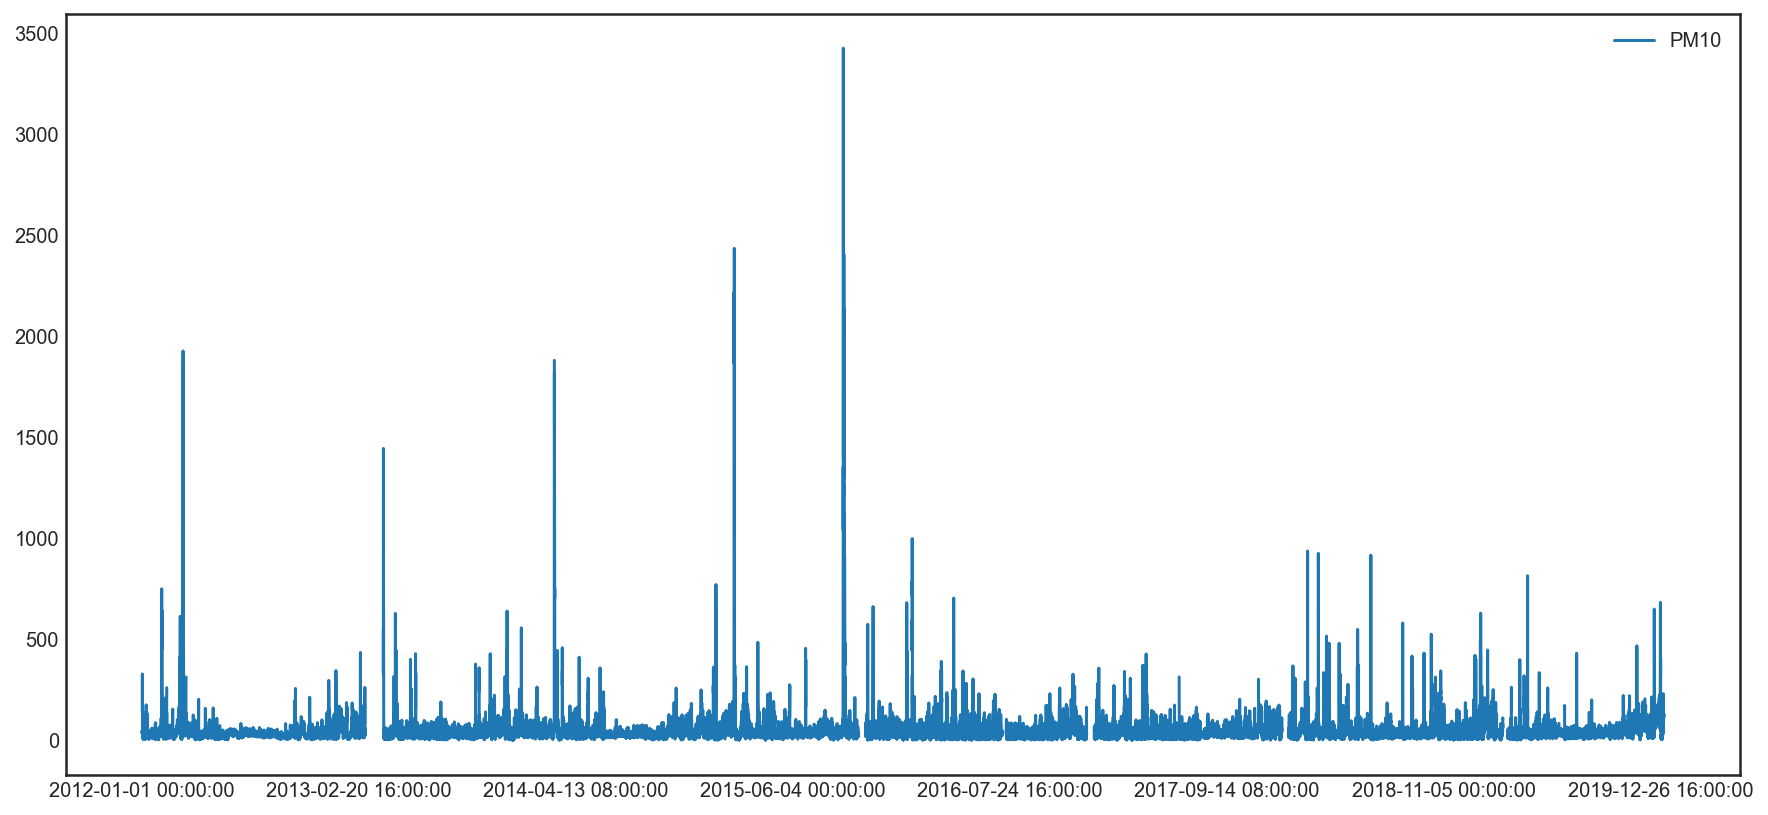

In [1368]:
fig, ax = plt.subplots(figsize=(15,7))
data_df.loc['AFULA']['PM10'].plot(ax=ax,legend=True)
# plt.legend(loc='lower right', bbox_to_anchor=(1.15, 0.5))
plt.show();

# ADD TRANSPORT DATA FROM DECELL

In [1369]:
stations_names

array(['AFULA', 'ANTOKOLSKY', 'HOLON', 'IRONID', 'KVISH4', 'REMEZ',
       'YEFET_YAFO', 'AHUZA_G', 'ATZMAUT_B', 'KIRYAT_ATA',
       'KIRYAT_BIALIK', 'KIRYAT_BINYAMIN', 'KIRYAT_TIVON', 'NAVE_SHANAAN',
       'NESHER', 'BAR_ILAN', 'EFRATA', 'ASHDOD_IGUD', 'ASHKELON_SOUTH',
       'GEDERA', 'GVARAAM', 'KIRYAT_MALAHI', 'NIR_ISRAEL', 'ORT',
       'ROVA_TV', 'SDEROT', 'SDE_YOAV', 'YAHALOM', 'BEER_SHEVA',
       'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA', 'RAANANA'],
      dtype=object)

In [1370]:
# 1-Private 2-Truck 3-Bus
for st in tqdm(stations_names):
    trans_2012_2019_dict = loadmat('/Users/iditbela/Documents/Broday/sent_from_Yuval/trans_'+ st +'_2012_2019.mat')
    data_df.loc[st,'private'] = trans_2012_2019_dict['traffic'].T[:,0]
    data_df.loc[st,'truck'] = trans_2012_2019_dict['traffic'].T[:,1]
    data_df.loc[st,'bus'] = trans_2012_2019_dict['traffic'].T[:,2]

HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

# ADD HOUR OF DAY, DAY OF WEEK, JULIAN DAY, TREND COLUMN(INDEX/TIMESTEMP)

In [1371]:
# can add it just to times. 
times_df = pd.DataFrame(pd.Series(times.values), columns = ['time'])

In [1372]:
# % The flagging of holidays is according to the following key:
# % 0 : Workdays
# % 10: Passover
# % 20: 7th of passover
# % 30: Independence Day
# % 4: LAG BAOMER
# % 50: Pentecost
# % 60: New Year
# % 70: 2nd day of New Year
# % 80: Attonment Day
# % 90: Sukkoth
# % 100: 7th of Sukkoth
# % 110: SHMINI ATZERET
# % The holidays dates were taken from the site:
# % http://rotter.net/luach.htm .
# 1.Year, 2.Month, 3.Day, 4.Hour, 5.Day of week; 6.Holidays tag; 7. Day in year';

TA_2012_2019_dict = loadmat('/Users/iditbela/Documents/Broday/sent_from_Yuval/Mon_DataBase/TimeAxis_2012#2019_fixed.mat')

In [1373]:
times_df['year'],times_df['month'],times_df['day'],times_df['hour'],times_df['day of week'],times_df['holidays'],times_df['day in year'] = TA_2012_2019_dict['TA']

In [1374]:
times_df

,time,year,month,day,hour,day of week,holidays,day in year
0,2012-01-01 00:00:00,2012.0,1.0,1.0,0.0,1.0,0.0,1.0
1,2012-01-01 00:30:00,2012.0,1.0,1.0,0.5,1.0,0.0,1.0
2,2012-01-01 01:00:00,2012.0,1.0,1.0,1.0,1.0,0.0,1.0
3,2012-01-01 01:30:00,2012.0,1.0,1.0,1.5,1.0,0.0,1.0
4,2012-01-01 02:00:00,2012.0,1.0,1.0,2.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...
140251,2019-12-31 21:30:00,2019.0,12.0,31.0,21.5,3.0,0.0,365.0
140252,2019-12-31 22:00:00,2019.0,12.0,31.0,22.0,3.0,0.0,365.0
140253,2019-12-31 22:30:00,2019.0,12.0,31.0,22.5,3.0,0.0,365.0
140254,2019-12-31 23:00:00,2019.0,12.0,31.0,23.0,3.0,0.0,365.0


# ADD STACK DATA FROM ILAN-LEVI - *2015 only*

In [1375]:
# Choose most important stacks
# Add to all stations columns of these stacks. Maybe divide by distance from measurement station (matters only if I do some analysis per all station...)

In [1376]:
# 2015
PM25_stacks_dict = loadmat('/Users/iditbela/Documents/Broday/stack_data_Ilan_Levy/PM25_stacks.mat')

In [1377]:
PM25_stacks_dict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'PM25_stacks', 'ReadmeStacks', 'StackLocs', 'StackNames'])

In [1575]:
StackLocs

array([[176416., 657288.],
       [176416., 657288.],
       [176416., 657288.],
       ...,
       [217516., 551415.],
       [217514., 551424.],
       [217570., 551403.]])

In [1378]:
PM25_stacks = PM25_stacks_dict['PM25_stacks']
StackLocs = PM25_stacks_dict['StackLocs'][:-1] #last index is nan 
StackNames = PM25_stacks_dict['StackNames'][:-1] #last index is nan 

In [1379]:
PM25_stacks.shape
np.shape(StackNames)

(2312, 12, 7, 48)

(2312, 1)

In [1380]:
# see which stacks emit most
values = np.median(PM25_stacks,axis=tuple(range(1, 4))) # mean half hourly emission rate... 

In [1381]:
# # OPTION-1
# unique,inverse = np.unique(StackNames,return_inverse=True)
# unique_sum = np.zeros((len(unique),))
# np.add.at(unique_sum, inverse, values)

# # unique
# # unique_sum

# sorted_emissions_idx = np.argsort(unique_sum)[::-1][:25]
# unique[sorted_emissions_idx]
# unique_sum[sorted_emissions_idx]

In [1476]:
unique_sum.shape

(498,)

In [1485]:
# OPTION-2 (faster) I'm not sure what I did here. 
unique,index,inverse, counts = np.unique(StackNames,return_index=True,return_inverse=True, return_counts=True)
unique_SN = StackNames[index]
unique_sum = np.bincount(inverse, values) #to get the average I would divide by count (can return count from np.unique)

sorted_emissions_idx = np.argsort(unique_sum)[::-1][:17]
unique_SN[sorted_emissions_idx]
unique_sum[sorted_emissions_idx]

array([[array(['חברת חשמל תחנת הכח אורות רבין, חדרה'], dtype='<U35')],
       [array(['חברת חשמל תחנת הכח רוטנברג, אשקלון'], dtype='<U34')],
       [array(['חיפה כימיקלים בע"מ'], dtype='<U18')],
       [array(['מגנזיום ים המלח בע"מ'], dtype='<U20')],
       [array(['חברת חשמל תחנת הכח חגית'], dtype='<U23')],
       [array(['רותם אמפרט נגב בע"מ'], dtype='<U19')],
       [array(['חברת חשמל תחנת הכח רמת חובב'], dtype='<U27')],
       [array(['תנובה מחלבת תל יוסף'], dtype='<U19')],
       [array(['מפעלי ים המלח'], dtype='<U13')],
       [array(['פריקלאס ים המלח בע"מ'], dtype='<U20')],
       [array(['חברת חשמל תחנת הכח צפית'], dtype='<U23')],
       [array(['אתגל אשדוד בע"מ'], dtype='<U15')],
       [array(['חברת חשמל תחנת הכח גזר'], dtype='<U22')],
       [array(['נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה'], dtype='<U39')],
       [array(['חברת חשמל תחנת הכח אשכול, אשדוד'], dtype='<U31')],
       [array(['חברת חשמל תחנת הכח חיפה'], dtype='<U23')],
       [array(['חברת חשמל תחנת הכח אלון תבו

array([170.35506049,  89.86718563,  41.39449257,  40.34186133,
        21.457     ,  20.73930527,  14.15351714,  11.52793105,
        10.5940905 ,  10.35728435,  10.1297    ,   9.62072   ,
         8.60299218,   7.25313867,   7.1175129 ,   6.16257967,
         5.63855428])

In [1385]:
# choose manually from the excell sheet (all those with emission rates > 3 kg/h of PM_fine)
# later maybe remove according to accumelative of the whole year

# relevant_stacks_names = ['חברת חשמל תחנת הכח אורות רבין, חדרה','חברת חשמל תחנת הכח רוטנברג, אשקלון','חיפה כימיקלים בע"מ','מגנזיום ים המלח בע"מ','סולל בונה פיתוח כבישים בע"מ','חברת חשמל תחנת הכח אלון תבור','חברת חשמל תחנת הכח רמת חובב','חברת חשמל תחנת הכח צפית','אתגל אשדוד בע"מ','רותם אמפרט נגב בע"מ','תנובה מחלבת תל יוסף','חברת חשמל תחנת הכח אשכול, אשדוד','חברת חשמל תחנת הכח חיפה','חברת חשמל תחנת הכח גזר','פריקלאס ים המלח בע"מ','חברת חשמל תחנת הכח חגית','נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה','אספלט אלפא','אמדאו','אפוקול בע"מ','מפעלי ים המלח','אייל ישר בע"מ','נילית בע"מ','אספלט פוריה','מכון למחזור פסדים העמק (1994)','פניציה אמריקה - ישראל בע"מ','חברת חשמל תחנת הכח רדינג, תל אביב','בית זקוק אשדוד','רותם אמפרט נגב בע"מ-מסוף פוספטים אשדוד']
# relevant_stacks_names = ['חברת חשמל תחנת הכח אורות רבין, חדרה','חברת חשמל תחנת הכח רוטנברג, אשקלון','חיפה כימיקלים בע"מ','סולל בונה פיתוח כבישים בע"מ','חברת חשמל תחנת הכח אלון תבור','חברת חשמל תחנת הכח רמת חובב','חברת חשמל תחנת הכח צפית','אתגל אשדוד בע"מ','חברת חשמל תחנת הכח אשכול, אשדוד','חברת חשמל תחנת הכח חיפה','חברת חשמל תחנת הכח גזר','חברת חשמל תחנת הכח חגית','נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה''חברת חשמל תחנת הכח רדינג, תל אביב','בית זקוק אשדוד','רותם אמפרט נגב בע"מ-מסוף פוספטים אשדוד']

relevant_stacks_names = np.array(unique_SN[sorted_emissions_idx][:,0].tolist()).ravel()

In [1392]:
relevant_stacks_names = np.append(relevant_stacks_names,'חברת חשמל תחנת הכח רדינג, תל אביב')

In [1393]:
relevant_stacks_names

array(['חברת חשמל תחנת הכח אורות רבין, חדרה',
       'חברת חשמל תחנת הכח רוטנברג, אשקלון', 'חיפה כימיקלים בע"מ',
       'מגנזיום ים המלח בע"מ', 'חברת חשמל תחנת הכח חגית',
       'רותם אמפרט נגב בע"מ', 'חברת חשמל תחנת הכח רמת חובב',
       'תנובה מחלבת תל יוסף', 'מפעלי ים המלח', 'פריקלאס ים המלח בע"מ',
       'חברת חשמל תחנת הכח צפית', 'אתגל אשדוד בע"מ',
       'חברת חשמל תחנת הכח גזר',
       'נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה',
       'חברת חשמל תחנת הכח אשכול, אשדוד', 'חברת חשמל תחנת הכח חיפה',
       'חברת חשמל תחנת הכח אלון תבור',
       'חברת חשמל תחנת הכח רדינג, תל אביב'], dtype='<U39')

### BE CAREFULL THIS WILL EMPTY EXISTING DATAFRAME

In [1394]:
# add empty columns of the chosen stacks (unique problem)
for st in tqdm(stations_names):
    for rsn in relevant_stacks_names:        
        data_df.loc[st,rsn] = np.zeros((times_df.shape[0],))

HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

In [1395]:
# # IN CASE I WANT TO DELETE COLUMNS (DOESNT WORK FOR SOME REASON)
# for st in tqdm(stations_names):
#     for rsn in relevant_stacks_names:        
#         data_df.loc[st].drop([rsn],axis=1,inplace=True)

In [1396]:
data_df

PM25  PM10   O3     NO   NO2    NOx  SO2     WD  \
AFULA   2012-01-01 00:00:00  21.05  36.0  7.5  117.5  30.4  147.9  1.8  126.0   
        2012-01-01 00:30:00  20.53  38.9  6.7   88.8  31.0  119.8  2.3   67.0   
        2012-01-01 01:00:00  20.67  47.0  7.0   90.2  26.3  116.5  1.4  309.0   
        2012-01-01 01:30:00  17.15  47.0  7.5  121.6  22.4  144.0  1.8  245.0   
        2012-01-01 02:00:00  19.68  47.0  8.0   77.3  21.0   98.3  1.9  144.0   
...                            ...   ...  ...    ...   ...    ...  ...    ...   
RAANANA 2019-12-31 21:30:00  17.00   NaN  NaN   11.4  34.7   46.0  NaN    NaN   
        2019-12-31 22:00:00  18.20   NaN  NaN    8.5  32.9   41.4  NaN    NaN   
        2019-12-31 22:30:00  19.00   NaN  NaN   11.1  33.0   44.2  NaN    NaN   
        2019-12-31 23:00:00  24.00   NaN  NaN   11.8  30.3   42.1  NaN    NaN   
        2019-12-31 23:30:00  22.46   NaN  NaN    NaN   NaN    NaN  NaN    NaN   

                              WS  StWD  ...  מפעלי ים המלח  \
AFULA   2012-01-01 00:00:00  0.2  31.4  ...            0.0   
        2012-01-01 00:30:00  0.2  26.1  ...            0.0   
        2012-01-01 01:00:00  0.2  16.9  ...            0.0   
        2012-01-01 01:30:00  0.2   6.1  ...            0.0   
        2012-01-01 02:00:00  0.4  25.0  ...            0.0   
...                          ...   ...  ...            ...   
RAANANA 2019-12-31 21:30:00  NaN   NaN  ...            0.0   
        2019-12-31 22:00:00  NaN   NaN  ...            0.0   
        2019-12-31 22:30:00  NaN   NaN  ...            0.0   
        2019-12-31 23:00:00  NaN   NaN  ...            0.0   
        2019-12-31 23:30:00  NaN   NaN  ...            0.0   

                             פריקלאס ים המלח בע"מ  חברת חשמל תחנת הכח צפית  \
AFULA   2012-01-01 00:00:00                   0.0                      0.0   
        2012-01-01 00:30:00                   0.0                      0.0   
        2012-01-01 01:00:00                   0.0                      0.0   
        2012-01-01 01:30:00                   0.0                      0.0   
        2012-01-01 02:00:00                   0.0                      0.0   
...                                           ...                      ...   
RAANANA 2019-12-31 21:30:00                   0.0                      0.0   
        2019-12-31 22:00:00                   0.0                      0.0   
        2019-12-31 22:30:00                   0.0                      0.0   
        2019-12-31 23:00:00                   0.0                      0.0   
        2019-12-31 23:30:00                   0.0                      0.0   

                             אתגל אשדוד בע"מ  חברת חשמל תחנת הכח גזר  \
AFULA   2012-01-01 00:00:00              0.0                     0.0   
        2012-01-01 00:30:00              0.0                     0.0   
        2012-01-01 01:00:00              0.0                     0.0   
        2012-01-01 01:30:00              0.0                     0.0   
        2012-01-01 02:00:00              0.0                     0.0   
...                                      ...                     ...   
RAANANA 2019-12-31 21:30:00              0.0                     0.0   
        2019-12-31 22:00:00              0.0                     0.0   
        2019-12-31 22:30:00              0.0                     0.0   
        2019-12-31 23:00:00              0.0                     0.0   
        2019-12-31 23:30:00              0.0                     0.0   

                             נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה  \
AFULA   2012-01-01 00:00:00                                      0.0   
        2012-01-01 00:30:00                                      0.0   
        2012-01-01 01:00:00                                      0.0   
        2012-01-01 01:30:00                                      0.0   
        2012-01-01 02:00:00                                      0.0   
...                                                              ...   
RAANAN

In [1397]:
# find an efficient way to add the data to the dataframe.
# add unique emisstion rates - create a 4D array of size 17X3D (chosen stacks) instead of 2000+
relevant_PM25_stacks = np.zeros((relevant_stacks_names.shape[0],PM25_stacks.shape[1],PM25_stacks.shape[2],PM25_stacks.shape[3]))

for i,rsn in enumerate(relevant_stacks_names):
    stack_idx = np.argwhere(StackNames==rsn)[:,0]
    relevant_PM25_stacks[i,:,:,:] = np.sum(PM25_stacks[stack_idx,:,:,:],axis=0)

In [1398]:
relevant_PM25_stacks.shape

(18, 12, 7, 48)

### BE CAREFUL - THIS IS A LONG RUN

In [1399]:
# for st in tqdm(stations_names):
st = 'AFULA'
idx = np.argwhere(pd.to_datetime(data_df.loc[st].index).year == 2015)
for i,rsn in enumerate(tqdm(relevant_stacks_names)):
    print(rsn)
    for ix in tqdm(idx):
        data_df.loc[st,rsn][ix] = relevant_PM25_stacks[i,int(times_df['month'].iloc[ix]-1),int(times_df['day of week'].iloc[ix]-1),int(times_df['hour'].iloc[ix]-1)]

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה


HBox(children=(IntProgress(value=0, max=17520), HTML(value='')))

חברת חשמל תחנת הכח רוטנברג, אשקלון


HBox(children=(IntProgress(value=0, max=17520), HTML(value='')))

חיפה כימיקלים בע"מ


HBox(children=(IntProgress(value=0, max=17520), HTML(value='')))

מגנזיום ים המלח בע"מ


HBox(children=(IntProgress(value=0, max=17520), HTML(value='')))

חברת חשמל תחנת הכח חגית


HBox(children=(IntProgress(value=0, max=17520), HTML(value='')))

רותם אמפרט נגב בע"מ


HBox(children=(IntProgress(value=0, max=17520), HTML(value='')))

חברת חשמל תחנת הכח רמת חובב


HBox(children=(IntProgress(value=0, max=17520), HTML(value='')))

תנובה מחלבת תל יוסף


HBox(children=(IntProgress(value=0, max=17520), HTML(value='')))

מפעלי ים המלח


HBox(children=(IntProgress(value=0, max=17520), HTML(value='')))

פריקלאס ים המלח בע"מ


HBox(children=(IntProgress(value=0, max=17520), HTML(value='')))

חברת חשמל תחנת הכח צפית


HBox(children=(IntProgress(value=0, max=17520), HTML(value='')))

אתגל אשדוד בע"מ


HBox(children=(IntProgress(value=0, max=17520), HTML(value='')))

חברת חשמל תחנת הכח גזר


HBox(children=(IntProgress(value=0, max=17520), HTML(value='')))

נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה


HBox(children=(IntProgress(value=0, max=17520), HTML(value='')))

חברת חשמל תחנת הכח אשכול, אשדוד


HBox(children=(IntProgress(value=0, max=17520), HTML(value='')))

חברת חשמל תחנת הכח חיפה


HBox(children=(IntProgress(value=0, max=17520), HTML(value='')))

חברת חשמל תחנת הכח אלון תבור


HBox(children=(IntProgress(value=0, max=17520), HTML(value='')))

חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=17520), HTML(value='')))

In [1400]:
data_df

PM25  PM10   O3     NO   NO2    NOx  SO2     WD  \
AFULA   2012-01-01 00:00:00  21.05  36.0  7.5  117.5  30.4  147.9  1.8  126.0   
        2012-01-01 00:30:00  20.53  38.9  6.7   88.8  31.0  119.8  2.3   67.0   
        2012-01-01 01:00:00  20.67  47.0  7.0   90.2  26.3  116.5  1.4  309.0   
        2012-01-01 01:30:00  17.15  47.0  7.5  121.6  22.4  144.0  1.8  245.0   
        2012-01-01 02:00:00  19.68  47.0  8.0   77.3  21.0   98.3  1.9  144.0   
...                            ...   ...  ...    ...   ...    ...  ...    ...   
RAANANA 2019-12-31 21:30:00  17.00   NaN  NaN   11.4  34.7   46.0  NaN    NaN   
        2019-12-31 22:00:00  18.20   NaN  NaN    8.5  32.9   41.4  NaN    NaN   
        2019-12-31 22:30:00  19.00   NaN  NaN   11.1  33.0   44.2  NaN    NaN   
        2019-12-31 23:00:00  24.00   NaN  NaN   11.8  30.3   42.1  NaN    NaN   
        2019-12-31 23:30:00  22.46   NaN  NaN    NaN   NaN    NaN  NaN    NaN   

                              WS  StWD  ...  מפעלי ים המלח  \
AFULA   2012-01-01 00:00:00  0.2  31.4  ...            0.0   
        2012-01-01 00:30:00  0.2  26.1  ...            0.0   
        2012-01-01 01:00:00  0.2  16.9  ...            0.0   
        2012-01-01 01:30:00  0.2   6.1  ...            0.0   
        2012-01-01 02:00:00  0.4  25.0  ...            0.0   
...                          ...   ...  ...            ...   
RAANANA 2019-12-31 21:30:00  NaN   NaN  ...            0.0   
        2019-12-31 22:00:00  NaN   NaN  ...            0.0   
        2019-12-31 22:30:00  NaN   NaN  ...            0.0   
        2019-12-31 23:00:00  NaN   NaN  ...            0.0   
        2019-12-31 23:30:00  NaN   NaN  ...            0.0   

                             פריקלאס ים המלח בע"מ  חברת חשמל תחנת הכח צפית  \
AFULA   2012-01-01 00:00:00                   0.0                      0.0   
        2012-01-01 00:30:00                   0.0                      0.0   
        2012-01-01 01:00:00                   0.0                      0.0   
        2012-01-01 01:30:00                   0.0                      0.0   
        2012-01-01 02:00:00                   0.0                      0.0   
...                                           ...                      ...   
RAANANA 2019-12-31 21:30:00                   0.0                      0.0   
        2019-12-31 22:00:00                   0.0                      0.0   
        2019-12-31 22:30:00                   0.0                      0.0   
        2019-12-31 23:00:00                   0.0                      0.0   
        2019-12-31 23:30:00                   0.0                      0.0   

                             אתגל אשדוד בע"מ  חברת חשמל תחנת הכח גזר  \
AFULA   2012-01-01 00:00:00              0.0                     0.0   
        2012-01-01 00:30:00              0.0                     0.0   
        2012-01-01 01:00:00              0.0                     0.0   
        2012-01-01 01:30:00              0.0                     0.0   
        2012-01-01 02:00:00              0.0                     0.0   
...                                      ...                     ...   
RAANANA 2019-12-31 21:30:00              0.0                     0.0   
        2019-12-31 22:00:00              0.0                     0.0   
        2019-12-31 22:30:00              0.0                     0.0   
        2019-12-31 23:00:00              0.0                     0.0   
        2019-12-31 23:30:00              0.0                     0.0   

                             נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה  \
AFULA   2012-01-01 00:00:00                                      0.0   
        2012-01-01 00:30:00                                      0.0   
        2012-01-01 01:00:00                                      0.0   
        2012-01-01 01:30:00                                      0.0   
        2012-01-01 02:00:00                                      0.0   
...                                                              ...   
RAANAN

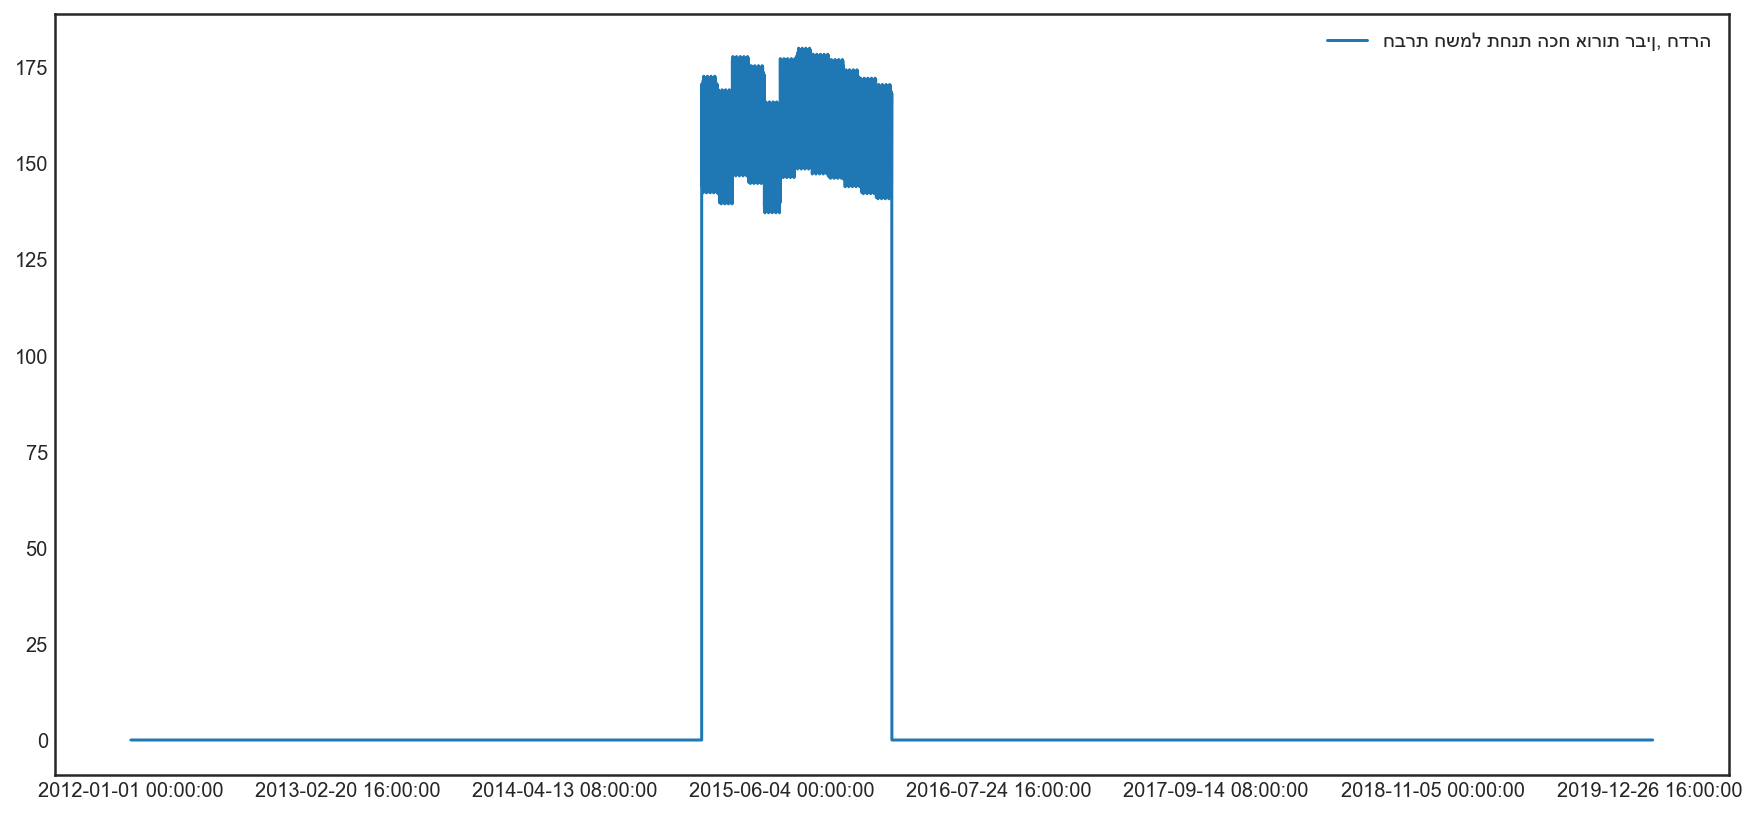

In [1486]:
fig, ax = plt.subplots(figsize=(15,7))
data_df.loc['PARDES_HANA']['חברת חשמל תחנת הכח אורות רבין, חדרה'].plot(ax=ax,legend=True)
# plt.legend(loc='lower right', bbox_to_anchor=(1.15, 0.5))
plt.show();

In [1402]:
# SHOULD REPLICATE AFULA NOW TO ALL STATIONS.

for st in tqdm(stations_names):
    if (st == 'AFULA'):
        continue
    idx = np.argwhere(pd.to_datetime(data_df.loc[st].index).year == 2015).ravel()
    for i,rsn in enumerate(tqdm(relevant_stacks_names)):
        print(rsn)
        data_df.loc[st,rsn][idx] = data_df.loc['AFULA',rsn][idx]

HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

חברת חשמל תחנת הכח אורות רבין, חדרה
חברת חשמל תחנת הכח רוטנברג, אשקלון
חיפה כימיקלים בע"מ
מגנזיום ים המלח בע"מ
חברת חשמל תחנת הכח חגית
רותם אמפרט נגב בע"מ
חברת חשמל תחנת הכח רמת חובב
תנובה מחלבת תל יוסף
מפעלי ים המלח
פריקלאס ים המלח בע"מ
חברת חשמל תחנת הכח צפית
אתגל אשדוד בע"מ
חברת חשמל תחנת הכח גזר
נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה
חברת חשמל תחנת הכח אשכול, אשדוד
חברת חשמל תחנת הכח חיפה
חברת חשמל תחנת הכח אלון תבור
חברת חשמל תחנת הכח רדינג, תל אביב



#### estimate the average hourly emission rate [kg/h] of relevant stacks (Might be that I took some irrelevent ones)

In [1487]:
relevant_stacks_names

array(['חברת חשמל תחנת הכח אורות רבין, חדרה',
       'חברת חשמל תחנת הכח רוטנברג, אשקלון', 'חיפה כימיקלים בע"מ',
       'מגנזיום ים המלח בע"מ', 'חברת חשמל תחנת הכח חגית',
       'רותם אמפרט נגב בע"מ', 'חברת חשמל תחנת הכח רמת חובב',
       'תנובה מחלבת תל יוסף', 'מפעלי ים המלח', 'פריקלאס ים המלח בע"מ',
       'חברת חשמל תחנת הכח צפית', 'אתגל אשדוד בע"מ',
       'חברת חשמל תחנת הכח גזר',
       'נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה',
       'חברת חשמל תחנת הכח אשכול, אשדוד', 'חברת חשמל תחנת הכח חיפה',
       'חברת חשמל תחנת הכח אלון תבור',
       'חברת חשמל תחנת הכח רדינג, תל אביב'], dtype='<U39')

In [1576]:
Loc = []
val = []
for rs in relevant_stacks_names:
    Loc.append(StackLocs[np.argwhere(StackNames == rs)[0,0],:])
    val.append(data_df.loc['AFULA'][rs].describe()['mean'])

In [1577]:
stackLocations = pd.DataFrame([],columns=['stack_name','X','Y','mean_hourly_emission_rate'])

In [1578]:
stackLocations['stack_name']= relevant_stacks_names

In [1579]:
stackLocations[['X','Y']]= Loc

In [1580]:
stackLocations['mean_hourly_emission_rate']= val

In [1582]:
stackLocations.head(1)

,stack_name,X,Y,mean_hourly_emission_rate
0,"חברת חשמל תחנת הכח אורות רבין, חדרה",189500,708242,19.904888


In [1588]:
gdf = gp.read_file("/Users/iditbela/Documents/Broday/GIS/IsraelBorder/IsraelBorder.shp")

In [1590]:
gdf.crs

<Projected CRS: EPSG:2039>
Name: Israel 1993 / Israeli TM Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Asia - Middle East - Israel and Palestine Territory onshore
- bounds: (34.17, 29.45, 35.69, 33.28)
Coordinate Operation:
- name: Israeli TM
- method: Transverse Mercator
Datum: Israel 1993
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [1597]:
from pyproj import Transformer

transformer = Transformer.from_crs("epsg:2039", "epsg:4326")
transformer.transform(stackLocations['X'].values,stackLocations['Y'].values)[0]

array([34.88586401, 34.52123935, 35.06436046, 35.35959543, 35.04199091,
       35.19553793, 34.81478334, 35.40100249, 35.37266856, 35.19389421,
       34.84003051, 34.67099231, 34.91543683, 34.89683504, 34.65567119,
       35.02120398, 35.36738066, 34.77885036])

In [1598]:
stackLocations['Lat'] = transformer.transform(stackLocations['X'].values,stackLocations['Y'].values)[0]
stackLocations['Lon'] = transformer.transform(stackLocations['X'].values,stackLocations['Y'].values)[1]

In [1601]:
stackLocations['stack_name_eng'] = ['IEC Rabin','IEC Rotenberg','Haifa chemicals','Dead-Sea Mg','IEC Hagit','Rotem','IEC Ramat Hovav','Tnuva Tel-Yosef','Dead-Sea Works','Periclase Dead Sea','IEC Tzafit','Etgal Ashdod','IEC Gezer','Nesher','IEC Ashdod','IEC Haifa','IEC Alon Tavor','IEC Reading']

In [1602]:
stackLocations.to_pickle('/Users/iditbela/Documents/Broday/saved_data_from_notebooks/stackLocations')

# save/read to pickle

In [1404]:
# data_df.to_pickle('/Users/iditbela/Documents/Broday/saved_data_from_notebooks/data_df')
# times_df.to_pickle('/Users/iditbela/Documents/Broday/saved_data_from_notebooks/times_df')
data_df = pd.read_pickle('/Users/iditbela/Documents/Broday/saved_data_from_notebooks/data_df')
times_df = pd.read_pickle('/Users/iditbela/Documents/Broday/saved_data_from_notebooks/times_df')

In [1405]:
# edit times_df
times_df.drop(['day','month'],axis=1, inplace=True)

In [1406]:
times_df['year']= times_df['year'].astype(int)
times_df['year']= times_df['year'].astype(str)

times_df['day of week']= times_df['day of week'].astype(int)
times_df['day of week']= times_df['day of week'].astype(str)

times_df['holidays']= times_df['holidays'].astype(int)
times_df['holidays']= times_df['holidays'].astype(str)

times_df['day in year']= times_df['day in year'].astype(int)
times_df['day in year']= times_df['day in year'].astype(str)

In [1407]:
data_df.head()

PM25  PM10   O3     NO   NO2    NOx  SO2     WD  \
AFULA 2012-01-01 00:00:00  21.05  36.0  7.5  117.5  30.4  147.9  1.8  126.0   
      2012-01-01 00:30:00  20.53  38.9  6.7   88.8  31.0  119.8  2.3   67.0   
      2012-01-01 01:00:00  20.67  47.0  7.0   90.2  26.3  116.5  1.4  309.0   
      2012-01-01 01:30:00  17.15  47.0  7.5  121.6  22.4  144.0  1.8  245.0   
      2012-01-01 02:00:00  19.68  47.0  8.0   77.3  21.0   98.3  1.9  144.0   

                            WS  StWD  ...  מפעלי ים המלח  \
AFULA 2012-01-01 00:00:00  0.2  31.4  ...            0.0   
      2012-01-01 00:30:00  0.2  26.1  ...            0.0   
      2012-01-01 01:00:00  0.2  16.9  ...            0.0   
      2012-01-01 01:30:00  0.2   6.1  ...            0.0   
      2012-01-01 02:00:00  0.4  25.0  ...            0.0   

                           פריקלאס ים המלח בע"מ  חברת חשמל תחנת הכח צפית  \
AFULA 2012-01-01 00:00:00                   0.0                      0.0   
      2012-01-01 00:30:00                   0.0                      0.0   
      2012-01-01 01:00:00                   0.0                      0.0   
      2012-01-01 01:30:00                   0.0                      0.0   
      2012-01-01 02:00:00                   0.0                      0.0   

                           אתגל אשדוד בע"מ  חברת חשמל תחנת הכח גזר  \
AFULA 2012-01-01 00:00:00              0.0                     0.0   
      2012-01-01 00:30:00              0.0                     0.0   
      2012-01-01 01:00:00              0.0                     0.0   
      2012-01-01 01:30:00              0.0                     0.0   
      2012-01-01 02:00:00              0.0                     0.0   

                           נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה  \
AFULA 2012-01-01 00:00:00                                      0.0   
      2012-01-01 00:30:00                                      0.0   
      2012-01-01 01:00:00                                      0.0   
      2012-01-01 01:30:00                                      0.0   
      2012-01-01 02:00:00                                      0.0   

                           חברת חשמל תחנת הכח אשכול, אשדוד  \
AFULA 2012-01-01 00:00:00                              0.0   
      2012-01-01 00:30:00                              0.0   
      2012-01-01 01:00:00                              0.0   
      2012-01-01 01:30:00                              0.0   
      2012-01-01 02:00:00                              0.0   

                           חברת חשמל תחנת הכח חיפה  \
AFULA 2012-01-01 00:00:00                      0.0   
      2012-01-01 00:30:00                      0.0   
      2012-01-01 01:00:00                      0.0   
      2012-01-01 01:30:00                      0.0   
      2012-01-01 02:00:00                      0.0   

                           חברת חשמל תחנת הכח אלון תבור  \
AFULA 2012-01-01 00:00:00                           0.0   
      2012-01-01 00:30:00                           0.0   
      2012-01-01 01:00:00                           0.0   
      2012-01-01 01:30:00                           0.0   
      2012-01-01 02:00:00                           0.0   

                           חברת חשמל תחנת הכח רדינג, תל אביב  
AFULA 2012-01-01 00:00:00                                0.0  
      2012-01-01 00:30:00                                0.0  
      2012-01-01 01:00:00                                0.0  
      2012-01-01 01:30:00                                0.0  
      2012-01-01 02:00:00                                0.0  

[5 rows x 47 columns]

In [1408]:
times_df.head()

,time,year,hour,day of week,holidays,day in year
0,2012-01-01 00:00:00,2012,0.0,1,0,1
1,2012-01-01 00:30:00,2012,0.5,1,0,1
2,2012-01-01 01:00:00,2012,1.0,1,0,1
3,2012-01-01 01:30:00,2012,1.5,1,0,1
4,2012-01-01 02:00:00,2012,2.0,1,0,1


In [1409]:
data_df.columns

Index(['PM25', 'PM10', 'O3', 'NO', 'NO2', 'NOx', 'SO2', 'WD', 'WS', 'StWD',
       'Temp', 'RH', 'SR', 'Rain', 'CO', 'Benzene', 'Toluene', 'BP', 'met_WD',
       'met_WS', 'met_StWD', 'met_Temp', 'met_RH', 'met_Rain', 'met_SR',
       'met_BP', 'private', 'truck', 'bus',
       'חברת חשמל תחנת הכח אורות רבין, חדרה',
       'חברת חשמל תחנת הכח רוטנברג, אשקלון', 'חיפה כימיקלים בע"מ',
       'מגנזיום ים המלח בע"מ', 'חברת חשמל תחנת הכח חגית',
       'רותם אמפרט נגב בע"מ', 'חברת חשמל תחנת הכח רמת חובב',
       'תנובה מחלבת תל יוסף', 'מפעלי ים המלח', 'פריקלאס ים המלח בע"מ',
       'חברת חשמל תחנת הכח צפית', 'אתגל אשדוד בע"מ', 'חברת חשמל תחנת הכח גזר',
       'נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה',
       'חברת חשמל תחנת הכח אשכול, אשדוד', 'חברת חשמל תחנת הכח חיפה',
       'חברת חשמל תחנת הכח אלון תבור', 'חברת חשמל תחנת הכח רדינג, תל אביב'],
      dtype='object')

In [1410]:
# from scipy import stats
# np.corrcoef(temp_df)
# stats.spearmanr(temp_df)

In [21]:
# sns.pairplot(temp_df)

# CREATE PM25 POLAR PLOTS FOR EACH STATION (interactive)

In [12]:
from scipy import stats
from ipywidgets import interact,SelectMultiple
import ipywidgets as widgets
# https://stackoverflow.com/questions/44423694/plotting-windrose-making-a-pollution-rose-with-concentration-set-to-color

In [13]:
df,times,stations,gdf = initialize() # initialize to get times

In [14]:
times.shape
data_df.shape

(140256, 1)

(4628448, 46)

In [15]:
def plot_polar(x,y,z):
    
    binx = np.linspace(0,2*np.pi)
    biny = np.linspace(0, 24, num=24)
    ret = stats.binned_statistic_2d(x, y, z, statistic=np.nanmedian, bins=[binx, biny])
#     print(ret.statistic.T.shape)
#     print(ret.statistic.T)

    Theta, R = np.meshgrid(binx[:-1], biny[:-1]) # not sure about this
    # Theta.shape
    # R.shape

    cmap = plt.get_cmap('cool')
    fig, ax = plt.subplots(subplot_kw={"projection":"polar"},figsize = (10,10))
    PC = ax.pcolormesh(Theta, R, ret.statistic.T,cmap=cmap,vmin=0, vmax=60)
    cbar = plt.colorbar(PC)

    ax.grid(True)
    plt.show();
     

In [22]:
selectMultiple = widgets.SelectMultiple(
    options=list(stations_names),
    value=['ANTOKOLSKY'],
    description='Stations',
    disabled=False,
)

@interact(variables=selectMultiple)

def f(variables):
       
    temp_df = data_df.loc[variables]
    _,times,_,_ = initialize() # initialize to get times
    
    pm_threshold = 60 
    # remove dust storms in 2015
    time_condition = [(((times.time>='2015-02-10 00:00:00') & (times.time<='2015-02-12 23:30:00')) | ((times.time>='2015-09-07 00:00:00') & (times.time<='2015-09-12 23:30:00'))) 
                          | ((temp_df['PM25'].values > pm_threshold))]
    idx_to_drop = np.argwhere(time_condition)[:,1]
    temp_df.drop(times.iloc[idx_to_drop].time,axis = 0, inplace=True)
    times.drop(idx_to_drop,axis = 0, inplace=True)
    
#     chosen_months = [12,1,2] #winter
#     chosen_months = [6,7,8] #summer
    chosen_months = [1,2,3,4,5,6,7,8,9,10,11,12]

    temp_df['month'] = pd.to_datetime(times['time']).dt.month.values
    temp_df_copy = temp_df.copy()
    temp_df = temp_df_copy[temp_df.month.isin(chosen_months)]
    # temp_df.drop(['month'],axis = 1, inplace =True)

    if temp_df['WD'].all():
        x = temp_df['met_WD'].values*2*np.pi/360 # wind direction (in radians so *2*np.pi/360)
        y = temp_df['met_WS'].values # wind speed
    else:
        x = temp_df['WD'].values*2*np.pi/360 # wind direction (in radians so *2*np.pi/360)
        y = temp_df['WS'].values # wind speed
    
    z = temp_df['PM25'] # concentrations
    
    plot_polar(x,y,z)
    

interactive(children=(SelectMultiple(description='Stations', index=(1,), options=('AFULA', 'ANTOKOLSKY', 'HOLON', 'IRONID', 'KVISH4', 'REMEZ', 'YEFET_YAFO', 'AHUZA_G', 'ATZMAUT_B', 'KIRYAT_ATA', 'KIRYAT_BIALIK', 'KIRYAT_BINYAMIN', 'KIRYAT_TIVON', 'NAVE_SHANAAN', 'NESHER', 'BAR_ILAN', 'EFRATA', 'ASHDOD_IGUD', 'ASHKELON_SOUTH', 'GEDERA', 'GVARAAM', 'KIRYAT_MALAHI', 'NIR_ISRAEL', 'ORT', 'ROVA_TV', 'SDEROT', 'SDE_YOAV', 'YAHALOM', 'BEER_SHEVA', 'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA', 'RAANANA'), value=('ANTOKOLSKY',)), Output()), _dom_classes=('widget-interact',))

# Find which feature is most important (xgboost on ALL PM25 and on factors)

#### Function

In [1411]:
def choose_year(temp_df, temp_times, s_year, e_year):
    chosen = temp_df[(temp_df.index <= str(e_year)+'-12-31 23:30:00') & (temp_df.index > str(s_year-1)+'-12-31 23:30:00')]
    s_idx = np.argwhere([temp_df.index == str(s_year)+'-01-01 00:00:00'])[0][1]
    e_idx = np.argwhere([temp_df.index == str(e_year+1)+'-01-01 00:00:00'])[0][1]
    return chosen, temp_times[s_idx:e_idx], s_idx, e_idx

def plot_time_series_sections_2(df,list_of_factors,weekend_removed):
    
    df['datetime'] = pd.to_datetime(temp_df.index, format='%Y-%m-%d %H:%M')
    df['month'] = pd.to_datetime(temp_df.index).month
    df['hour'] = pd.to_datetime(temp_df.index).hour
    df['minute'] = pd.to_datetime(temp_df.index).minute
    df['Day in year'] = pd.to_datetime(temp_df.index).dayofyear
  
    df['week day'] = pd.to_datetime(temp_df.index).dayofweek+1
    print(df['week day'].unique())
    df.loc[df['week day']==7,'week day']=0
    print(df['week day'].unique()) 
    
    cm = sns.color_palette(None, len(list_of_factors))
    
    mpl.style.use('seaborn-white')
    # https://nextjournal.com/bebi5009/matplotlib-tutorial
    fig = plt.figure(figsize=(12,11))
    grid = plt.GridSpec(3, 1)  # 2 rows 3 cols
    ax1 = plt.subplot(grid[0,:1])  # top left
    df.groupby(['Day in year'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax1,legend=False)
    # ax1.legend(loc='upper right')
    plt.xlim([-1,368])
    plt.xticks(np.linspace(15,365-15,12), ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'))
    plt.xlabel('\nDay in the year')
    ax1.legend(bbox_to_anchor=(1.1, 1), loc=2 ,frameon=True)

    ax2 = plt.subplot(grid[1,:1])   # middle left
    df.groupby(['week day','hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax2,legend=False)
    
    
    if weekend_removed:
        # If friday and saturday were removed
        plt.xlim([-1,48*5+1])
        plt.xticks(np.linspace(24,48*5-24,5), ('Sun', 'Mon','Tue','Wed','Thu'))
    else:    
        plt.xlim([-1,48*7+1])
        plt.xticks(np.linspace(24,48*7-24,7), ('Sun', 'Mon','Tue','Wed','Thu','Fri','Sat'))

    plt.xlabel('\nHour in the week')

    ax3 = plt.subplot(grid[2,:1])  # bottom left
    df.groupby(['hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax3,legend=False)
    plt.xlim([0,47])
    plt.xticks(np.linspace(1,48-1,24), [str(i) for i in range(24)])
    plt.xlabel('\nHour in the day')

    fig.tight_layout()
    plt.show();
    

In [1412]:
# # CHANGE WIND DIRECTION TO U,V WHERE WIND SPEED IS 1 (AND KEEP WIND SPEED COLUMN AS IS)?
# from metpy.calc import wind_components
# # wind_components(speed, wdir)

In [1413]:
st = 'ASHDOD_IGUD'
temp_df = data_df.loc[st]
temp_df['holidays'] = temp_times['holidays'].values
# temp_df['NOx_KVISH4'] = data_df.loc['KVISH4'].NOx.values
temp_df.head()

,PM25,PM10,O3,NO,NO2,NOx,SO2,WD,WS,StWD,...,"פריקלאס ים המלח בע""מ",חברת חשמל תחנת הכח צפית,"אתגל אשדוד בע""מ",חברת חשמל תחנת הכח גזר,"נשר- מפעלי מלט ישראליים בע""מ, מפעל רמלה","חברת חשמל תחנת הכח אשכול, אשדוד",חברת חשמל תחנת הכח חיפה,חברת חשמל תחנת הכח אלון תבור,"חברת חשמל תחנת הכח רדינג, תל אביב",holidays
2012-01-01 00:00:00,30.1,NaN,13.0,0.1,10.3,10.4,0.0,176.0,3.5,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-01 00:30:00,27.1,NaN,14.8,0.0,9.2,9.2,0.0,177.0,3.7,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-01 01:00:00,21.5,NaN,17.2,0.0,7.6,7.6,0.0,175.0,3.7,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-01 01:30:00,20.0,NaN,18.0,0.0,7.3,7.3,0.0,175.0,3.6,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-01 02:00:00,27.9,NaN,16.8,0.0,8.4,8.4,0.0,171.0,3.7,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1414]:
temp_times = times_df.copy()

In [1415]:
temp_times.head()

,time,year,hour,day of week,holidays,day in year
0,2012-01-01 00:00:00,2012,0.0,1,0,1
1,2012-01-01 00:30:00,2012,0.5,1,0,1
2,2012-01-01 01:00:00,2012,1.0,1,0,1
3,2012-01-01 01:30:00,2012,1.5,1,0,1
4,2012-01-01 02:00:00,2012,2.0,1,0,1


[7 1 2 3 4 5 6]
[0 1 2 3 4 5 6]


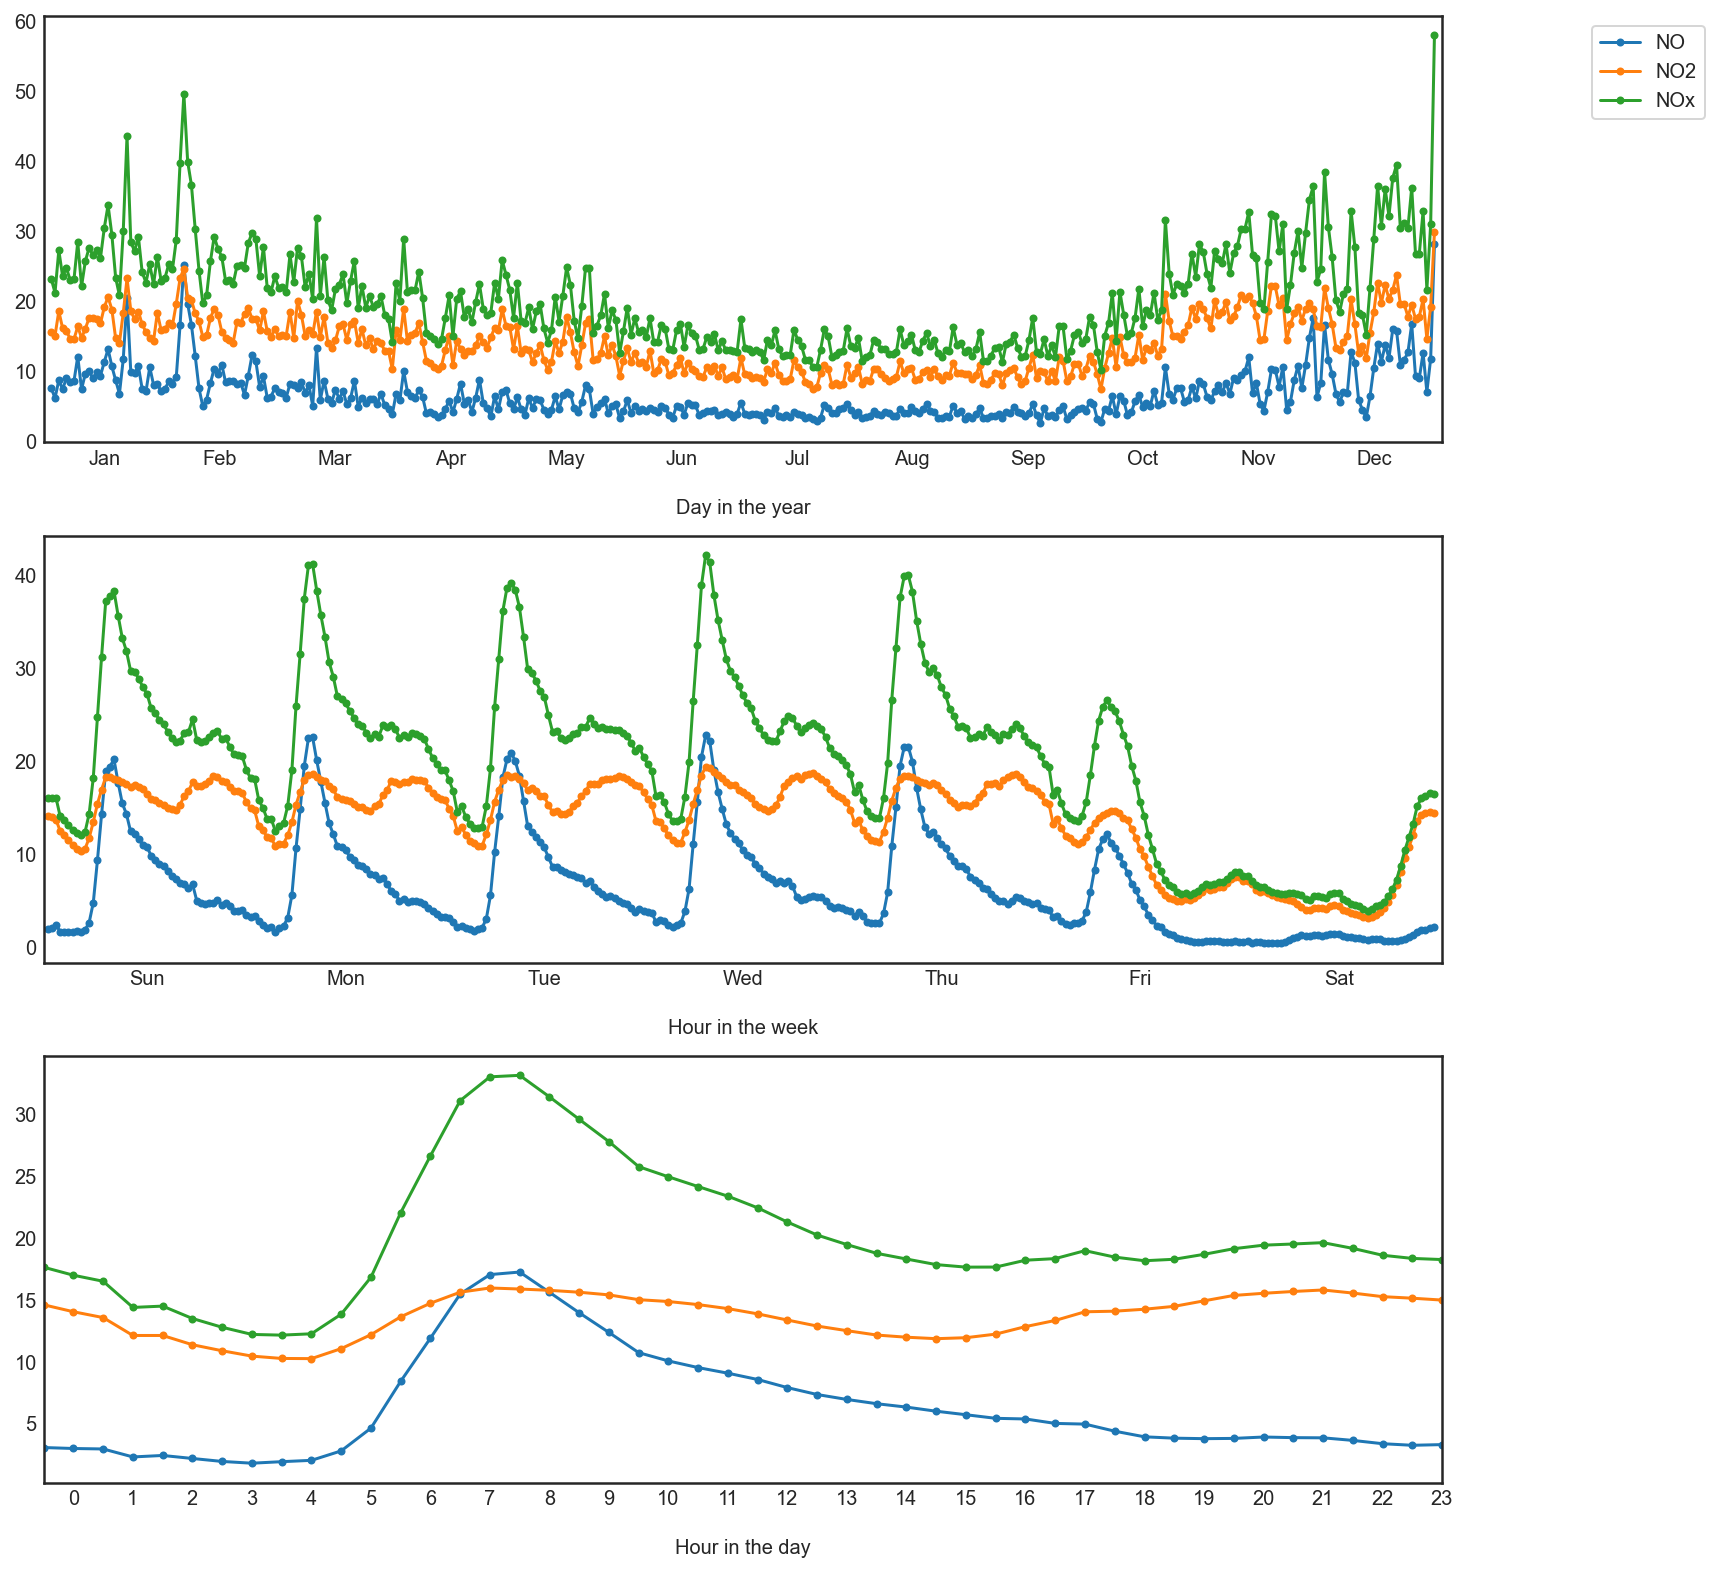

In [1474]:
# plot signals IN THE STATION
to_plot = ['NO','NO2','NOx']#['PM25','RH','Temp','met_SR']#'חברת חשמל תחנת הכח אשכול, אשדוד' #'PM25'#'WS'#'NOx' #'PM25'#'bus'#'truck'#'private'

# with dust storms in 2015 removed:
plot_time_series_sections_2(temp_df,to_plot,False)

In [1417]:
# from scipy import stats
# temp_df['WS'].corr(temp_df['PM25'])
# coef, p = stats.spearmanr(temp_df['WS'], temp_df['PM25'])

In [1418]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.inspection import permutation_importance

from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error #=mean error (Simon 2012)
from sklearn.metrics import r2_score

In [1419]:
s_year = 2015
e_year = 2015
chosen, chosen_times, s_idx, e_idx = choose_year(temp_df, temp_times, s_year, e_year)

In [1420]:
chosen.shape
chosen_times.shape

(17520, 54)

(17520, 6)

In [1421]:
# remove index of time
chosen.reset_index(drop=True, inplace=True)
chosen_times.reset_index(drop=True, inplace=True)

In [1422]:
# extreme events in 2015

time_condition = [(((chosen_times.time>='2015-02-10 00:00:00') & (chosen_times.time<='2015-02-12 23:30:00')) | ((chosen_times.time>='2015-09-07 00:00:00') & (chosen_times.time<='2015-09-12 23:30:00'))) 
#                   | ((chosen_times.time>='2015-11-03 02:00:00') & (chosen_times.time<='2015-11-06 12:00:00'))
#                   | ((chosen_times.time>='2015-01-06 07:30:00') & (chosen_times.time<='2015-01-08 10:00:00'))
                 ]

idx_to_drop_2015 = np.argwhere(time_condition)[:,1]
chosen.drop(idx_to_drop_2015,axis = 0, inplace=True)
chosen_times.drop(idx_to_drop_2015,axis = 0, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1423]:
# idx_to_drop_2015

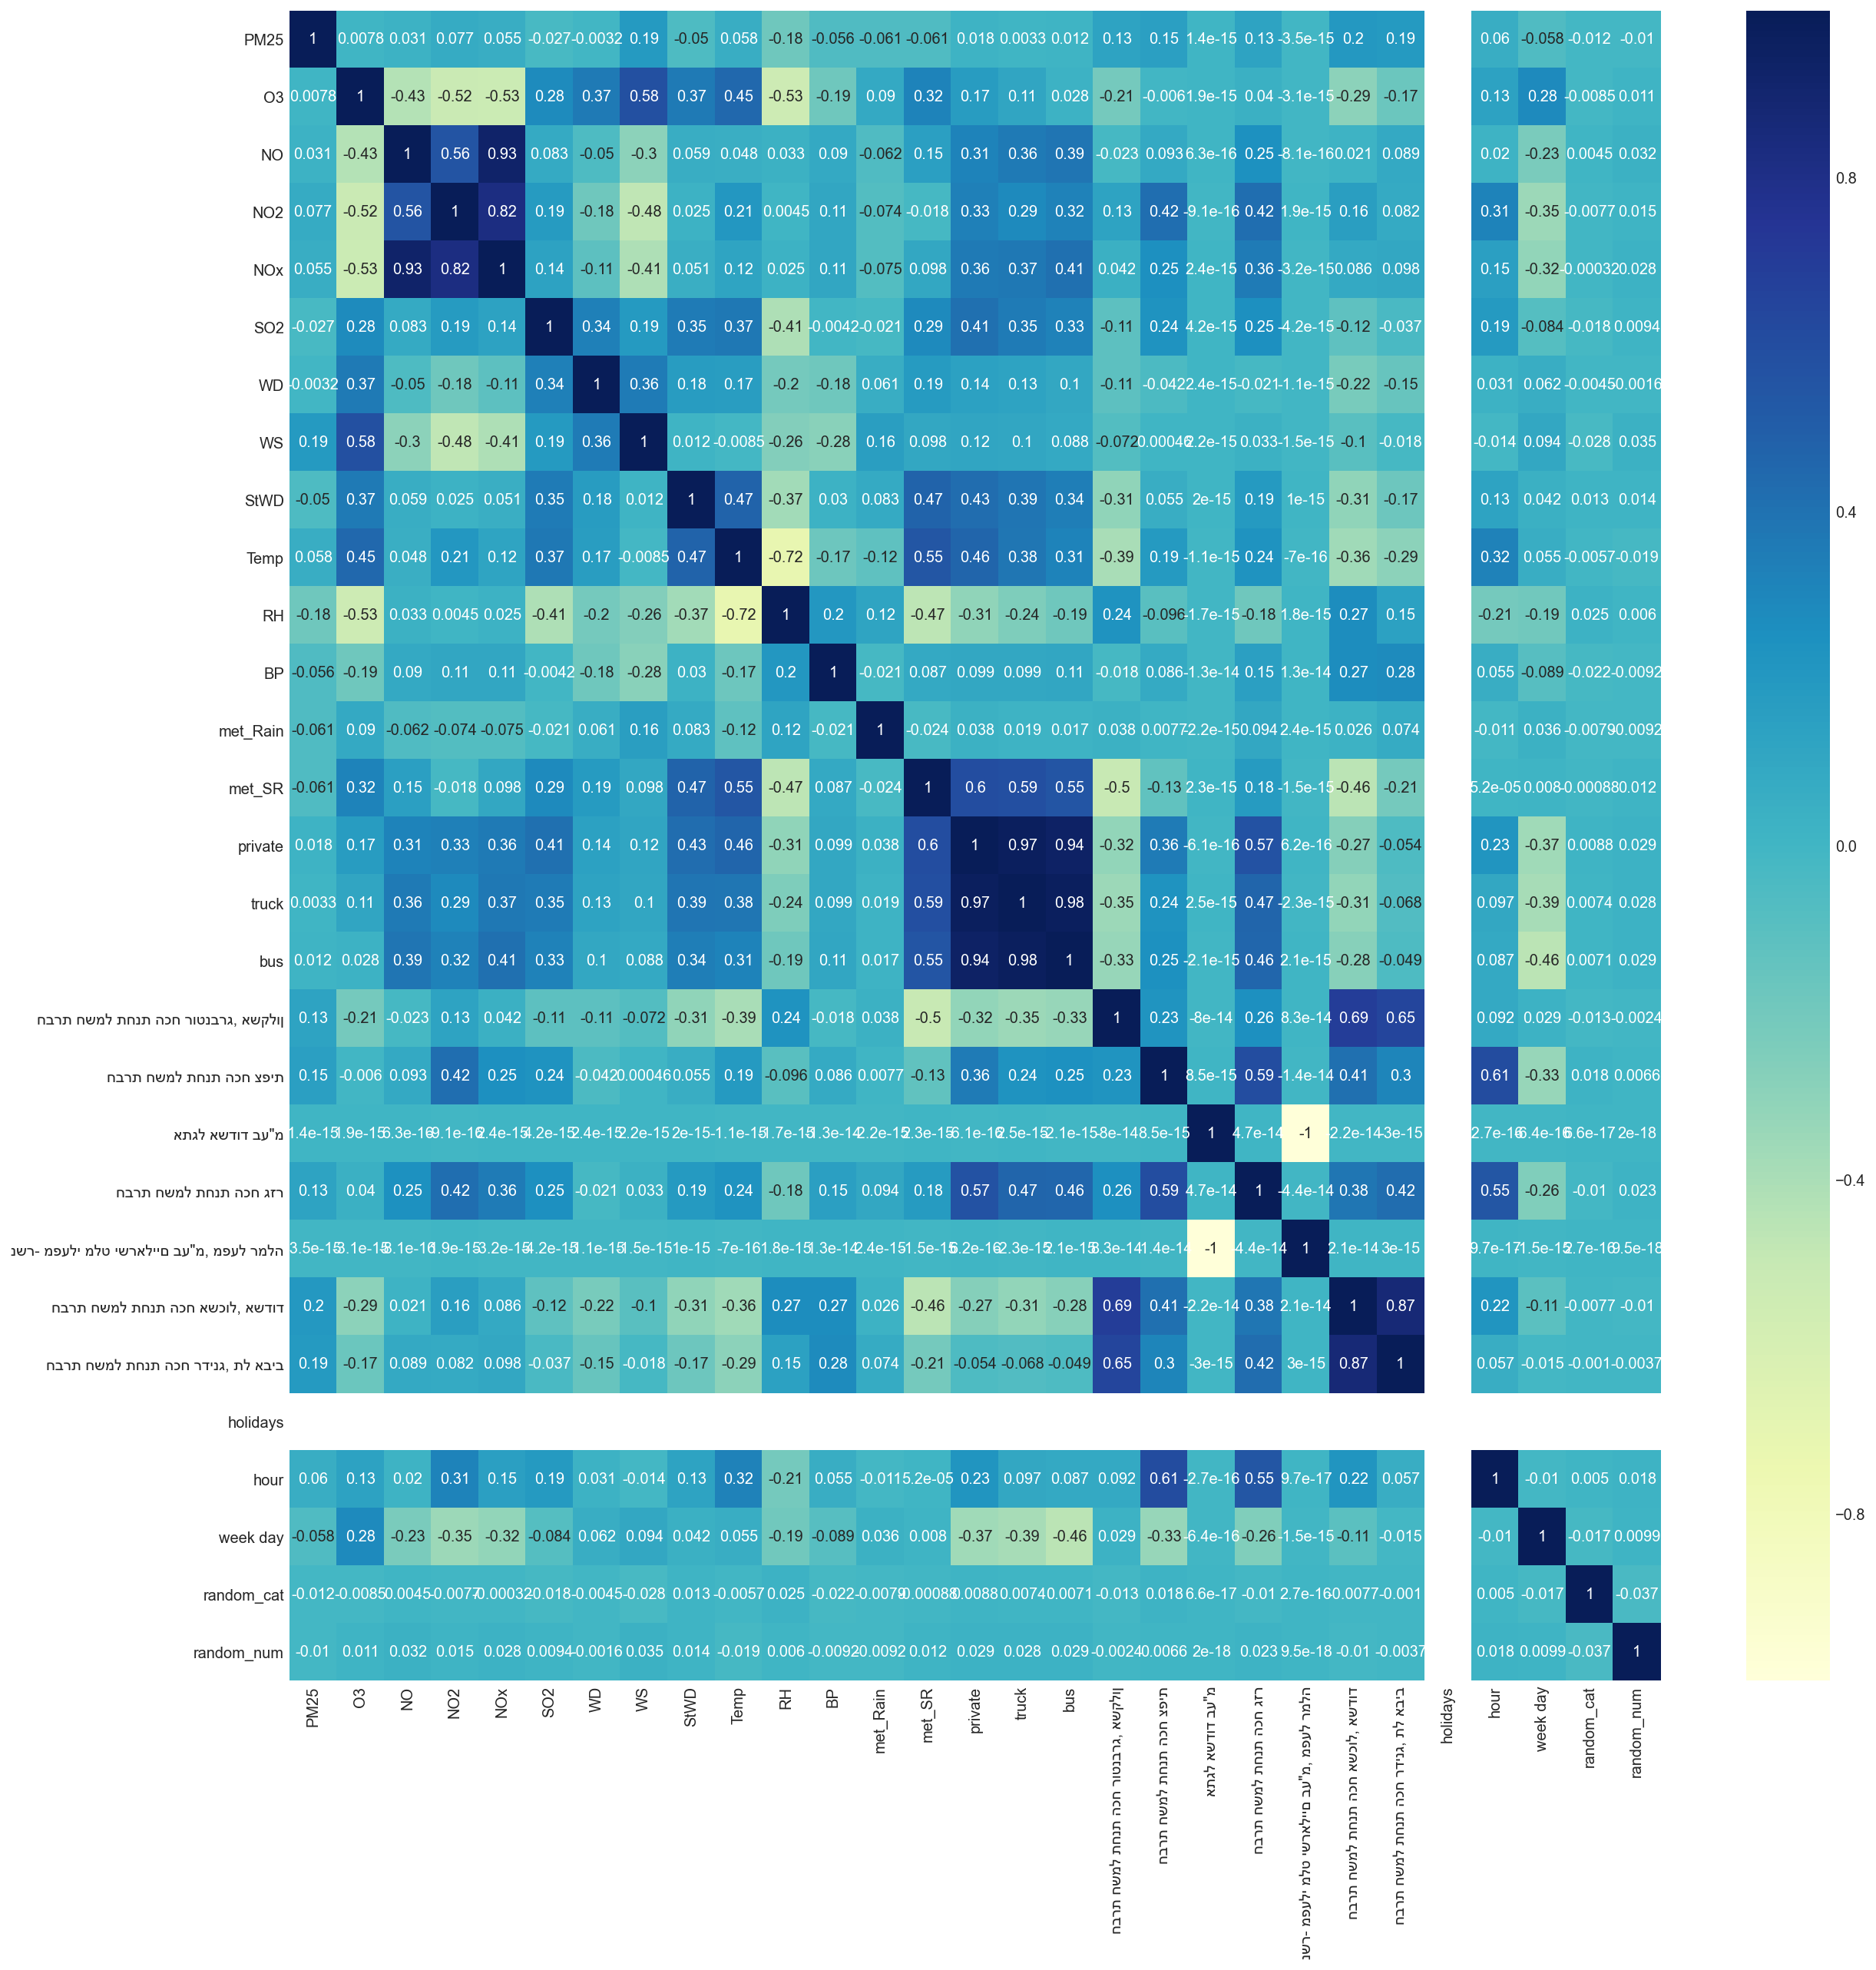

In [1469]:
def correlation_heatmap(subset):
    correlations = subset.corr()

    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(correlations, cmap="YlGnBu", annot=True)
#                 , vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
#                 square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
#                 )
    plt.show();

subset = chosen[:3000]

correlation_heatmap(subset)

In [1425]:
chosen.columns

Index(['PM25', 'PM10', 'O3', 'NO', 'NO2', 'NOx', 'SO2', 'WD', 'WS', 'StWD',
       'Temp', 'RH', 'SR', 'Rain', 'CO', 'Benzene', 'Toluene', 'BP', 'met_WD',
       'met_WS', 'met_StWD', 'met_Temp', 'met_RH', 'met_Rain', 'met_SR',
       'met_BP', 'private', 'truck', 'bus',
       'חברת חשמל תחנת הכח אורות רבין, חדרה',
       'חברת חשמל תחנת הכח רוטנברג, אשקלון', 'חיפה כימיקלים בע"מ',
       'מגנזיום ים המלח בע"מ', 'חברת חשמל תחנת הכח חגית',
       'רותם אמפרט נגב בע"מ', 'חברת חשמל תחנת הכח רמת חובב',
       'תנובה מחלבת תל יוסף', 'מפעלי ים המלח', 'פריקלאס ים המלח בע"מ',
       'חברת חשמל תחנת הכח צפית', 'אתגל אשדוד בע"מ', 'חברת חשמל תחנת הכח גזר',
       'נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה',
       'חברת חשמל תחנת הכח אשכול, אשדוד', 'חברת חשמל תחנת הכח חיפה',
       'חברת חשמל תחנת הכח אלון תבור', 'חברת חשמל תחנת הכח רדינג, תל אביב',
       'holidays', 'datetime', 'month', 'hour', 'minute', 'Day in year',
       'week day'],
      dtype='object')

In [1426]:
# drop irrelevant vars
VARS_TO_DROP = ['PM10','SR','Rain','CO','Benzene','Toluene','met_WD','met_WS','met_StWD','datetime','met_Temp', 'met_RH','met_BP','minute'
#                 ,'hour','week day'
                ,'Day in year','month' # day in year and month is irrelevant if I only have one year!!!
                ,'חברת חשמל תחנת הכח אורות רבין, חדרה','חיפה כימיקלים בע"מ','חברת חשמל תחנת הכח חגית','רותם אמפרט נגב בע"מ','מפעלי ים המלח'
                ,'פריקלאס ים המלח בע"מ','חברת חשמל תחנת הכח חיפה','חברת חשמל תחנת הכח אלון תבור','חברת חשמל תחנת הכח רמת חובב','מגנזיום ים המלח בע"מ','תנובה מחלבת תל יוסף'
                ]

chosen.drop(VARS_TO_DROP,axis=1,inplace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1427]:
chosen.head()

,PM25,O3,NO,NO2,NOx,SO2,WD,WS,StWD,Temp,...,"חברת חשמל תחנת הכח רוטנברג, אשקלון",חברת חשמל תחנת הכח צפית,"אתגל אשדוד בע""מ",חברת חשמל תחנת הכח גזר,"נשר- מפעלי מלט ישראליים בע""מ, מפעל רמלה","חברת חשמל תחנת הכח אשכול, אשדוד","חברת חשמל תחנת הכח רדינג, תל אביב",holidays,hour,week day
0,19.9,1.5,18.4,25.3,43.7,1.1,138.0,2.6,8.0,12.6,...,91.592990,10.1297,9.62072,12.819526,7.253139,11.619554,1.283693,0.0,0,4
1,24.1,NaN,17.0,27.0,44.0,1.1,126.0,2.0,10.0,12.7,...,90.487858,10.1297,9.62072,11.272626,7.253139,9.788768,1.140112,0.0,0,4
2,22.4,NaN,19.8,25.1,45.0,NaN,128.0,1.7,14.0,12.8,...,90.487858,10.1297,9.62072,11.272626,7.253139,9.788768,1.140112,0.0,1,4
3,23.1,1.9,NaN,NaN,NaN,0.0,133.0,1.5,15.0,12.9,...,90.487858,10.1297,9.62072,11.272626,7.253139,9.788768,1.140112,0.0,1,4
4,22.6,1.4,22.9,25.0,47.9,0.0,165.0,2.1,11.0,12.8,...,90.487858,10.1297,9.62072,11.272626,7.253139,9.788768,1.140112,0.0,2,4


In [1428]:
chosen.columns

Index(['PM25', 'O3', 'NO', 'NO2', 'NOx', 'SO2', 'WD', 'WS', 'StWD', 'Temp',
       'RH', 'BP', 'met_Rain', 'met_SR', 'private', 'truck', 'bus',
       'חברת חשמל תחנת הכח רוטנברג, אשקלון', 'חברת חשמל תחנת הכח צפית',
       'אתגל אשדוד בע"מ', 'חברת חשמל תחנת הכח גזר',
       'נשר- מפעלי מלט ישראליים בע"מ, מפעל רמלה',
       'חברת חשמל תחנת הכח אשכול, אשדוד', 'חברת חשמל תחנת הכח רדינג, תל אביב',
       'holidays', 'hour', 'week day'],
      dtype='object')

In [1429]:
# subset = chosen[:3000]

# correlation_heatmap(subset)

In [1430]:
rng = np.random.RandomState(seed=42)
chosen['random_cat'] = rng.randint(3, size=chosen.shape[0])
chosen['random_num'] = rng.randn(chosen.shape[0])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1431]:
Y = chosen.PM25.values
X = chosen.drop('PM25',axis=1).values

In [1432]:
Y.shape
X.shape

(17088,)

(17088, 28)

In [1433]:
# seed = 0
# test_size = 0.2
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# model = XGBRegressor(importance_type = 'gain', num_parallel_tree=20, n_estimators=100, tree_method = 'hist', max_depth= 4, reg_alpha = 0, reg_lambda = 1) # try hist and gpu_hist
# # The above line will result in 100 stacked random forests with 50(num_parallel_tree) trees each. n_estimators(sklearn) = num_boost_round(native xgboost)

# #                      early_stopping_rounds=200)
# model.fit(X_train, y_train)

# # pd.DataFrame([100*model.feature_importances_], columns = df_AI.columns[1:])

# y_pred = model.predict(X_test)
# y_pred_train = model.predict(X_train)

# R2 = r2_score(y_train, y_pred_train)
# print( 'train R2 is: ' + str(R2))

# R2 = r2_score(y_test, y_pred)
# print( 'test R2 is: ' + str(R2))

In [1450]:
seed = 0
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# it stops after 100 iterations if using early_stopping_rounds=10, so I just take n_estimators=100 in advance
model = XGBRegressor(importance_type = 'gain', num_parallel_tree=20, n_estimators=100,max_depth= 5, reg_alpha = 0, reg_lambda = 1) #learning_rate = 0.29) # try hist and gpu_hist in tree_method
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["rmse", "rmse"], eval_set=eval_set, verbose=False) #, early_stopping_rounds=10)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

R2 = r2_score(y_train, y_pred_train)
print( 'train R2 is: ' + str(R2))

R2 = r2_score(y_test, y_pred)
print( 'test R2 is: ' + str(R2))

[09:18:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=5, num_parallel_tree=20)

train R2 is: 0.7227835799050447
test R2 is: 0.5740934085976507


In [ ]:
# MAYBE IT IS JUST ENOUGH TO DO A STATISTIC TO EACH STATION AND CHARACHTERIZE IT - WHICH VARIABLE 
# INFULENCE IT THE MOST?




In [981]:
# CLEAR OVERFITTING....SHOULD FIRST MAKE THE MODEL BETTER AND EVALUATE WITH CROSS-VALIDATION. 

In [982]:
# # Try EARLY STOPPING to avoid overfitting
# # https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

# model = XGBRegressor(importance_type = 'gain', num_parallel_tree=20, n_estimators=1000, tree_method = 'hist', max_depth= 5) # try hist and gpu_hist
# eval_set = [(X_train, y_train), (X_test, y_test)]
# model.fit(X_train, y_train, eval_metric=["rmse", "rmse"], eval_set=eval_set, verbose=True)

In [983]:
# from sklearn.metrics import accuracy_score

# # make predictions for test data
# y_pred = model.predict(X_test)
# y_pred_train = model.predict(X_train)

# predictions_test = [round(value) for value in y_pred]
# predictions_train = [round(value) for value in y_pred_train]

# # evaluate predictions
# R2_train = r2_score(y_train, predictions_train)
# print("R2: %.2f" % (R2_train))

# R2_test = r2_score(y_test, predictions_test)
# print("R2: %.2f" % (R2_test))

In [984]:
# results = model.evals_result()
# # print(results)
# # Each of ‘validation_0‘ and ‘validation_1‘ correspond to the order that datasets were provided to the eval_set argument in the call to fit().

In [985]:
# epochs = len(results['validation_0']['rmse'])
# x_axis = range(0, epochs)
# # plot rmse
# fig, ax = plt.subplots(figsize = (7,5))
# ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
# ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
# ax.legend()
# plt.ylabel('RMSE')
# plt.title('XGBoost RMSE')
# plt.show();

In [986]:
# I think that 100 n_estimators is ok, just try to avoid overfitting by regularization or max_depth.

In [987]:
# possibly - add hyperparameter tuning and CV
# https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
# https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

In [1451]:
# train and test gives the same results! I think by definition it is done on the train
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=chosen.drop(['PM25'],axis=1).columns)
# dtest = xgb.DMatrix(X_test, label=y_test, feature_names=chosen.drop(['PM25'],axis=1).columns)

mapper = {'f{0}'.format(i): v for i, v in enumerate(dtrain.feature_names)}
# mapper = {'f{0}'.format(i): v for i, v in enumerate(dtest.feature_names)}
mapped = {mapper[k]: v for k, v in model.get_booster().get_score(importance_type='gain').items()}

In [1452]:
# importance type: gain, weight (favourites high cardinality), cover, total_gain, total_cover 

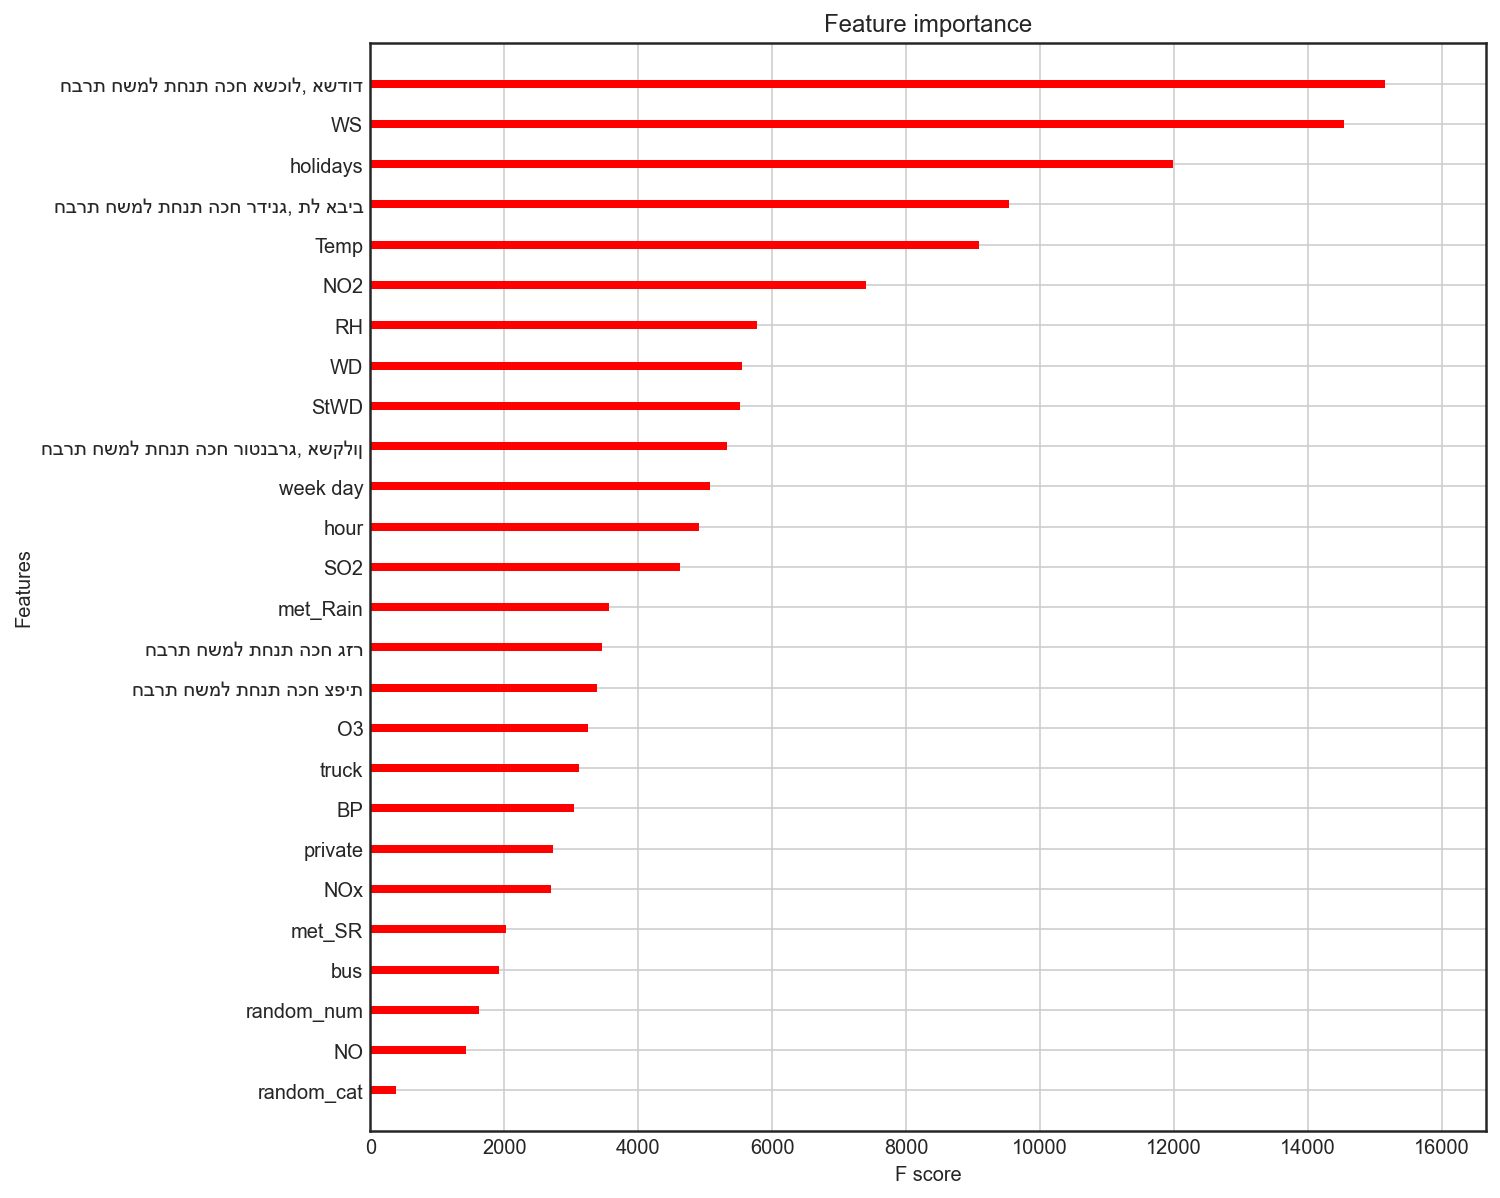

In [1453]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(mapped, color='red', importance_type='gain', ax=ax, show_values=False)

In [1454]:
# permutation importance

'''
Warning: Features that are deemed of low importance for a bad model (low cross-validation score) 
could be very important for a good model. Therefore it is always important to evaluate the predictive 
power of a model using a held-out set (or better with cross-validation) prior to computing importances.
Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how
important this feature is for a particular model.
'''

# note to self, remember that I will compare the importances of features of DIFFERENT MODELS. So I will have
# to show some general average importances?

'\nWarning: Features that are deemed of low importance for a bad model (low cross-validation score) \ncould be very important for a good model. Therefore it is always important to evaluate the predictive \npower of a model using a held-out set (or better with cross-validation) prior to computing importances.\nPermutation importance does not reflect to the intrinsic predictive value of a feature by itself but how\nimportant this feature is for a particular model.\n'

In [1455]:
# import sklearn.metrics as ss
# sorted(ss.SCORERS.keys())

#### Feature importance on test

In [1456]:
# it differs if I do on taining or testing! I think I need to do it over ALL DATA, after I finish training the model.
# This would be more close to making the permutation on "taining data"

# https://christophm.github.io/interpretable-ml-book/feature-importance.html
# https://compstat-lmu.github.io/iml_methods_limitations/pfi-data.html

# " Feature importance based on the training data tells us which features are important for the model in the sense that it depends on them for making predictions."
# "The feature importance based on training data makes us mistakenly believe that features are important for the predictions, when in reality the model was just overfitting and the features were not important at all."
# "you need to decide whether you want to know how much the model relies on each feature for making predictions (-> training data)"
# "or how much the feature contributes to the performance of the model on unseen data (-> test data). "

# neg_root_mean_squared_error
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, scoring='r2') # (default is r2), neg_mean_absolute_error, neg_root_mean_squared_error
# perm_importance = permutation_importance(model, X_train, y_train, n_repeats=30, scoring='r2')

In [1457]:
sorted_idx = perm_importance.importances_mean.argsort()

In [1458]:
# fig, ax = plt.subplots(figsize=(10, 10))
# plt.barh(np.array(dtrain.feature_names)[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel("Permutation Importance")
# plt.show();

In [1459]:
# It directly measures variable importance by observing the effect on model accuracy of randomly shuffling each predictor variable. This technique is broadly-applicable because it doesn't rely on internal model parameters, such as linear regression coefficients (which are really just poor proxies for feature importance).
# https://arxiv.org/abs/2006.04750

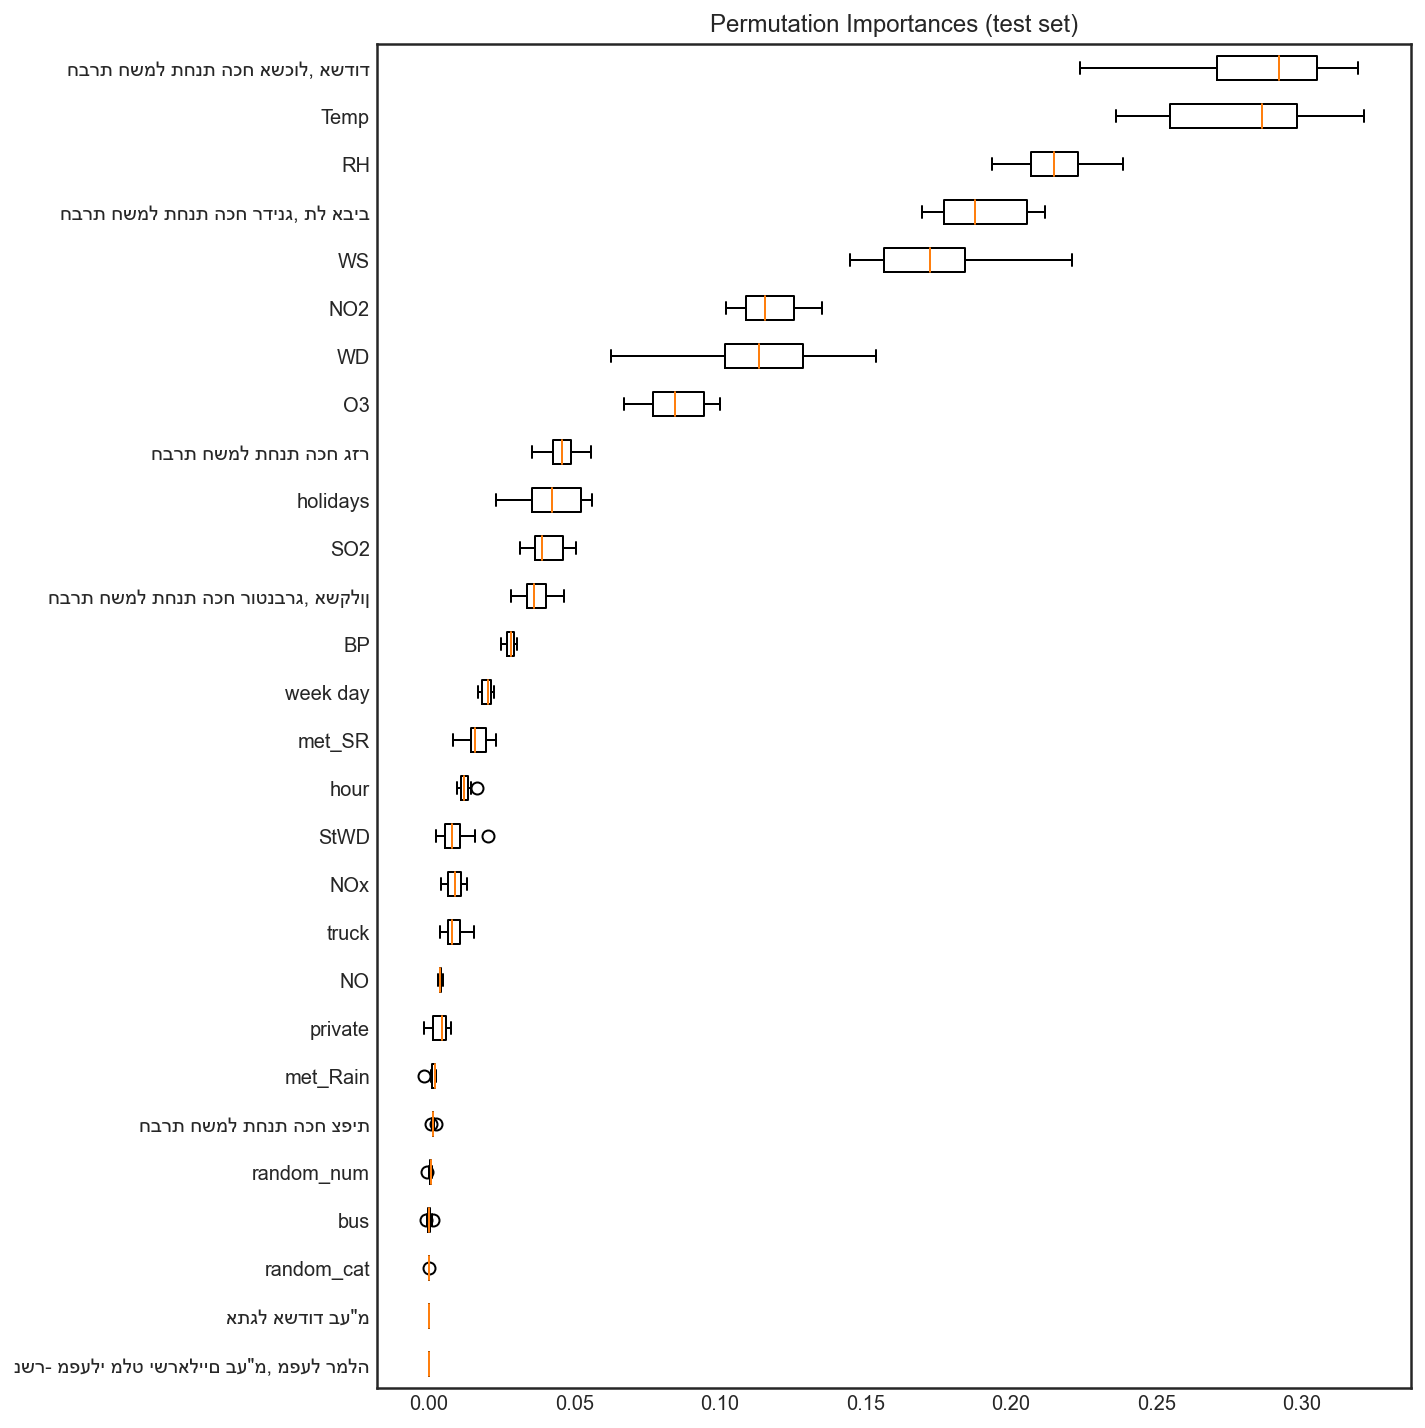

In [1460]:
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
fig, ax = plt.subplots(figsize=(10, 10))
ax.boxplot(perm_importance.importances[sorted_idx].T,
           vert=False, labels=np.array(dtrain.feature_names)[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show();

#### Feature importance on train

In [1183]:
# it differs if I do on taining or testing! I think I need to do it over ALL DATA, after I finish training the model.
# This would be more close to making the permutation on "taining data"

# https://christophm.github.io/interpretable-ml-book/feature-importance.html
# " Feature importance based on the training data tells us which features are important for the model in the sense that it depends on them for making predictions."
# "The feature importance based on training data makes us mistakenly believe that features are important for the predictions, when in reality the model was just overfitting and the features were not important at all."
# "you need to decide whether you want to know how much the model relies on each feature for making predictions (-> training data)"
# "or how much the feature contributes to the performance of the model on unseen data (-> test data). "

# perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, scoring='r2') # (default is r2), neg_mean_absolute_error, neg_root_mean_squared_error
perm_importance = permutation_importance(model, X_train, y_train, n_repeats=10, scoring='r2')

In [1184]:
sorted_idx = perm_importance.importances_mean.argsort()

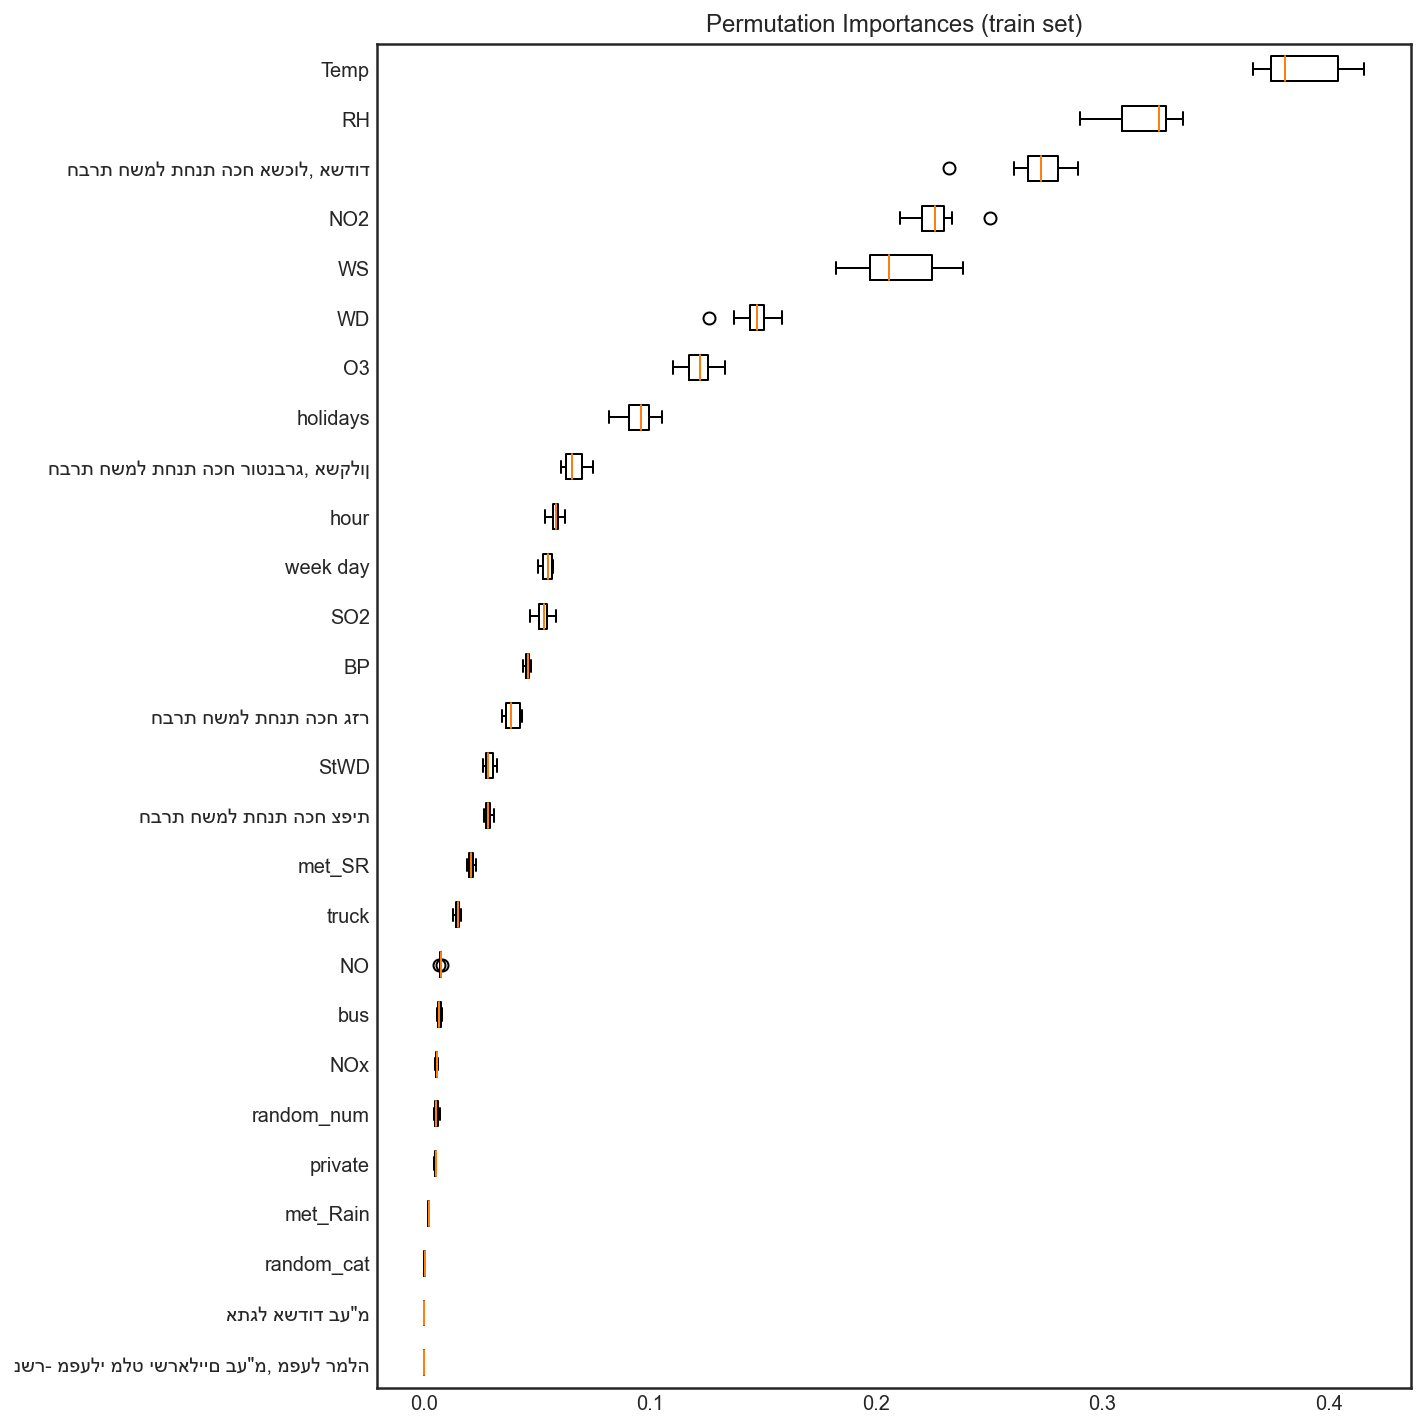

In [1185]:
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
fig, ax = plt.subplots(figsize=(10, 10))
ax.boxplot(perm_importance.importances[sorted_idx].T,
           vert=False, labels=np.array(dtrain.feature_names)[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show();

In [ ]:
# CONCLUSION: THE PFI is very sensitive to over and underfitting, this is why I should do a 
# hyperparameter tuning and cross validation to everything before. For a well-tuned model, the differences
# between test and train are not significant. 

# https://compstat-lmu.github.io/iml_methods_limitations/pfi-data.html

In [ ]:
# IT IS IN A WAY, A FORM OF SENSITIVITY ANALYSIS. IT MIGHT BE THAT I WOULD JUST WANT TO ESTIMATE 
# HOW MUCH OF THE MODEL'S OUTPUT VARIANCE IS EXPLAINED BY EACH FEATURE. 
# "Model variance (explained by the features) and feature importance correlate strongly when the model generalizes well (i.e. it does not overfit)."

#### CONCLUSIONS

1. Should tune the model well before using PFI
2. Should group together colliner features (tranffic, NOx...)
3. Power plants are predictive because they don't change(?) (data is based on factors). Do I have better data?
4. It might be that MANY factors could be better (10?)
5. In general, if doing FA with ALL variables, I will derive a LINEAR model with coefficients that might tell me the importance of the features (unlike a RF model which is non-linear). The advantage of the FA is that I can derive a time-series (only a normalized one unfortunately...) 

* maybe take all years, don't take pollutants (they are proxies for SOURCES) and don't take DECELL or STACK data, i.e., only meteorology. 

### Partial dependence plot

In [ ]:
# PDP allows us to see how a change in a predictor variable affects the change in the target variable

In [ ]:
from sklearn.inspection import plot_partial_dependence

In [ ]:
# fig, ax = plt.subplots()
# plot_partial_dependence(model, X_train, [3,6])
# plt.show();

In [ ]:
# dtrain.feature_names

### Doing the same with rfpimp package (random forest) - maybe will be better?

In [1462]:
from rfpimp import feature_corr_matrix, plot_corr_heatmap

In [1473]:
# viz = feature_corr_matrix(chosen)
# viz

### xgboost on factors of PM25 (should fix the install of factanal package in python....)

In [ ]:
# need to add:
# stability

#### WHEN FA is done only on 2015

In [1247]:
remove_weekends = False
# chosen_months = [12,1,2]
# chosen_months = [6,7,8]
chosen_months = [1,2,3,4,5,6,7,8,9,10,11,12]
# chosen_years = ['2015']

In [1248]:
# initialize to get times:
df,times,stations,gdf = initialize()

# choose the type of data I want to FA (i.e., REMOVE STATIONS/EXTREME EVENTS...)

# extreme events/only the dust storm
# pm_threshold = 60

# remove dust storms in 2015 and 100
time_condition = [(((times.time>='2015-02-10 00:00:00') & (times.time<='2015-02-12 23:30:00')) | ((times.time>='2015-09-07 00:00:00') & (times.time<='2015-09-12 23:30:00'))) 
#                   | ((times.time>='2015-11-03 02:00:00') & (times.time<='2015-11-06 12:00:00'))
#                   | ((times.time>='2015-01-06 07:30:00') & (times.time<='2015-01-08 10:00:00'))
#                   | ((df > pm_threshold).all(axis=1))
                 ]

idx_to_drop = np.argwhere(time_condition)[:,1]
df.drop(idx_to_drop,axis = 0, inplace=True)
times.drop(idx_to_drop,axis = 0, inplace=True)


# choose months
df['month'] = pd.to_datetime(times['time']).dt.month
times = times[df.month.isin(chosen_months)]
df = df[df.month.isin(chosen_months)]
df.drop(['month'],axis = 1, inplace =True)
# reset index!
df.reset_index(inplace=True)
df.drop(labels = 'index',axis=1, inplace=True)
times.reset_index(inplace=True)
times.drop(labels = 'index',axis=1, inplace=True)

# # choose years
# df['year'] = pd.to_datetime(times['time']).dt.year
# times = times[df.year.isin(chosen_years)]
# df = df[df.year.isin(chosen_years)]
# df.drop(['year'],axis = 1, inplace =True)
# # reset index!
# df.reset_index(inplace=True)
# df.drop(labels = 'index',axis=1, inplace=True)
# times.reset_index(inplace=True)
# times.drop(labels = 'index',axis=1, inplace=True)

# remove stations
STATIONS_TO_DROP = []
# STATIONS_TO_DROP = ['AFULA', 'KVISH4',
#        'YEFET_YAFO', 'KIRYAT_ATA', 'KIRYAT_BIALIK',  'NESHER', 'BAR_ILAN',
#        'EFRATA',  'ASHKELON_SOUTH', 'GEDERA',
#        'KIRYAT_MALAHI', 'ORT', 'ROVA_TV', 
#        'YAHALOM', 'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA',
#        'RAANANA']
# STATIONS_TO_DROP = ['BAR_ILAN','ATZMAUT_B','KIRYAT_BINYAMIN','KFAR_MASARIK','KIRYAT_TIVON','IRONID','KVISH4','REMEZ','YEFET_YAFO','RAANANA','EAST_NEGEV','EFRATA','AFULA','PARDES_HANA','BEER_SHEVA']
# traffic stations:
# STATIONS_TO_DROP = ['BAR_ILAN','IRONID','KVISH4','REMEZ','YEFET_YAFO','ATZMAUT_B','BAR_ILAN','RAANANA']
# distant stations:
# STATIONS_TO_DROP = ['IRONID','BAR_ILAN','YEFET_YAFO']


# ONLY SOUTH
STATIONS_TO_DROP = ['BAR_ILAN','AFULA', 'ANTOKOLSKY', 'HOLON', 'IRONID', 'KVISH4', 'REMEZ',
       'YEFET_YAFO', 'AHUZA_G', 'ATZMAUT_B', 'KIRYAT_ATA', 'KIRYAT_BIALIK',
       'KIRYAT_BINYAMIN', 'KIRYAT_TIVON', 'NAVE_SHANAAN', 'NESHER', 'EFRATA',
       'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA', 'RAANANA','BEER_SHEVA'] 

# # ONLY NORTH
# STATIONS_TO_DROP = ['BAR_ILAN','ANTOKOLSKY', 'HOLON', 'IRONID', 'KVISH4', 'REMEZ',
#        'YEFET_YAFO','EFRATA','ASHDOD_IGUD', 'ASHKELON_SOUTH', 'GEDERA', 'GVARAAM', 'KIRYAT_MALAHI',
#        'NIR_ISRAEL', 'ORT', 'ROVA_TV', 'SDEROT', 'SDE_YOAV', 'YAHALOM',
#        'BEER_SHEVA', 'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA', 'RAANANA']#,'ATZMAUT_B','AFULA']

# # ONLY CENTER
# STATIONS_TO_DROP = ['AFULA', 'ANTOKOLSKY', 'IRONID', 'KVISH4', 'REMEZ',
#        'YEFET_YAFO', 'AHUZA_G', 'ATZMAUT_B', 'KIRYAT_ATA', 'KIRYAT_BIALIK',
#        'KIRYAT_BINYAMIN', 'KIRYAT_TIVON', 'NAVE_SHANAAN', 'NESHER', 'BAR_ILAN',
#        'EFRATA', 'ASHDOD_IGUD', 'ASHKELON_SOUTH', 'GEDERA', 'GVARAAM',
#        'KIRYAT_MALAHI', 'NIR_ISRAEL', 'SDEROT', 'SDE_YOAV',
#        'BEER_SHEVA', 'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA',
#        'RAANANA']# 'ORT', 'ROVA_TV'

df.drop(STATIONS_TO_DROP,axis=1,inplace=True)

# RESET INDEX!!!!
times.reset_index(inplace=True,drop=True)
df.reset_index(inplace=True,drop=True)

In [1249]:
# LOAD RESULTS FROM R
df_load = pd.read_csv('/tmp/loadings.csv')

column_names = df_load['Unnamed: 0'].values

df_load.drop(columns = 'Unnamed: 0',inplace=True)

df_scores = pd.read_csv('/tmp/scores.csv')
df_scores.drop(columns = 'Unnamed: 0',inplace=True)

In [1250]:
NUM = 4
weekend_removed = False

[7 1 2 3 4 5 6]
[0 1 2 3 4 5 6]


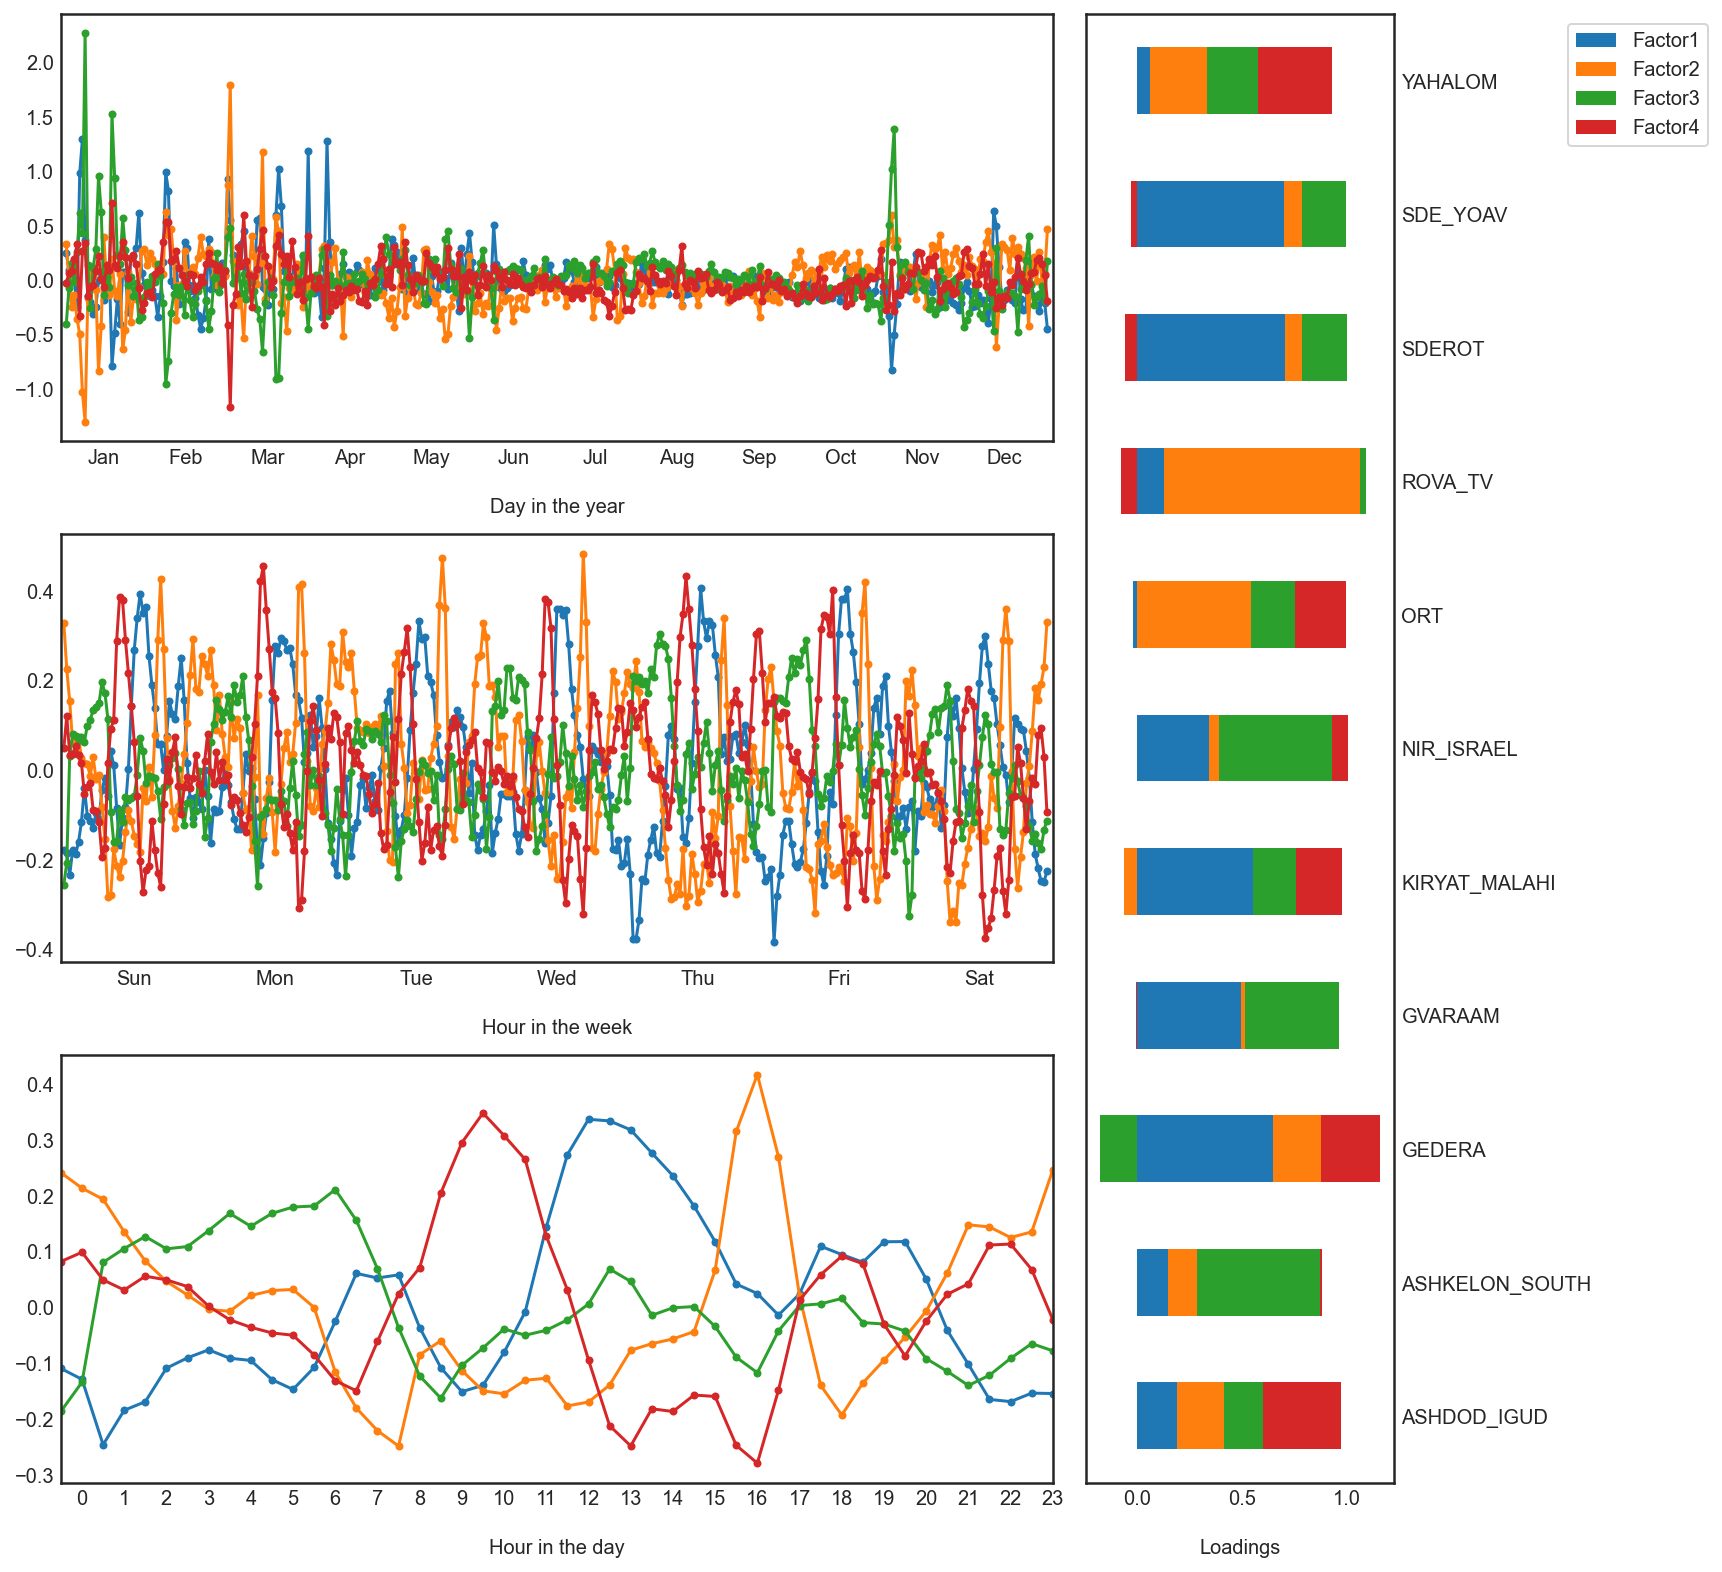

In [1251]:
list_of_factors = ['Factor'+str(i+1) for i in range(NUM)]
# list_of_factors = ['scores.ML'+str(i+1) for i in range(NUM)]
# list_of_factors = ['ML'+str(i+1) for i in range(NUM)]

# df_load = pd.DataFrameFrame(Loadings,columns=list_of_factors)
# df_scores = pd.DataFrame(scores, columns=list_of_factors)
df_scores = add_group_columns_to_df_scores(df_scores,times)

plot_factors_and_loadings(df_scores,df_load, list_of_factors, column_names, weekend_removed=weekend_removed)

In [1267]:
df_load.head(1)

,Factor1,Factor2,Factor3,Factor4
0,0.188019,0.227572,0.183816,0.373669


In [1253]:
# LF
f = 'Factor4'
Z = np.dot(df_load[f].values.reshape(-1,1),np.transpose(df_scores[f].values.reshape(-1,1))).T
df_Z = pd.DataFrame.from_records(Z,columns=df.columns)

In [1254]:
Y = df_Z[st][s_idx:e_idx].values
X = chosen.drop('PM25',axis=1).values

In [1255]:
Y.shape
X.shape

(17520,)

(17088, 27)

In [1256]:
Y = np.delete(Y, idx_to_drop_2015)
Y.shape

(17088,)

In [1257]:
seed = 0
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# it stops after 100 iterations if using early_stopping_rounds=10, so I just take n_estimators=100 in advance
model = XGBRegressor(importance_type = 'gain', num_parallel_tree=20, n_estimators=100, tree_method = 'hist', max_depth= 5, reg_alpha = 0, reg_lambda = 1) # try hist and gpu_hist
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["rmse", "rmse"], eval_set=eval_set, verbose=False) #, early_stopping_rounds=10)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

R2 = r2_score(y_train, y_pred_train)
print( 'train R2 is: ' + str(R2))

R2 = r2_score(y_test, y_pred)
print( 'test R2 is: ' + str(R2))

[21:30:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=5, num_parallel_tree=20, tree_method='hist')

train R2 is: 0.4804728728836283
test R2 is: 0.11757641981745737


In [1258]:
# # train and test gives the same results! I think by definition it is done on the train
# dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=chosen.drop(['PM25'],axis=1).columns)
# # dtest = xgb.DMatrix(X_test, label=y_test, feature_names=chosen.drop(['PM25'],axis=1).columns)

# mapper = {'f{0}'.format(i): v for i, v in enumerate(dtrain.feature_names)}
# # mapper = {'f{0}'.format(i): v for i, v in enumerate(dtest.feature_names)}
# mapped = {mapper[k]: v for k, v in model.get_booster().get_score(importance_type='gain').items()}

In [1259]:
# importance type: gain, weight (favourites high cardinality), cover, total_gain, total_cover 

In [1260]:
# fig, ax = plt.subplots(figsize=(10, 10))
# xgb.plot_importance(mapped, color='red', importance_type='gain', ax=ax, show_values=False)

#### Feature importance on test

In [1261]:
# neg_root_mean_squared_error
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, scoring='r2') # (default is r2), neg_mean_absolute_error, neg_root_mean_squared_error
# perm_importance = permutation_importance(model, X_train, y_train, n_repeats=30, scoring='r2')

In [1262]:
sorted_idx = perm_importance.importances_mean.argsort()

In [1263]:
np.shape(dtrain.feature_names)

(27,)

In [1264]:
# fig, ax = plt.subplots(figsize=(10, 10))
# plt.barh(np.array(dtrain.feature_names)[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel("Permutation Importance")
# plt.show();

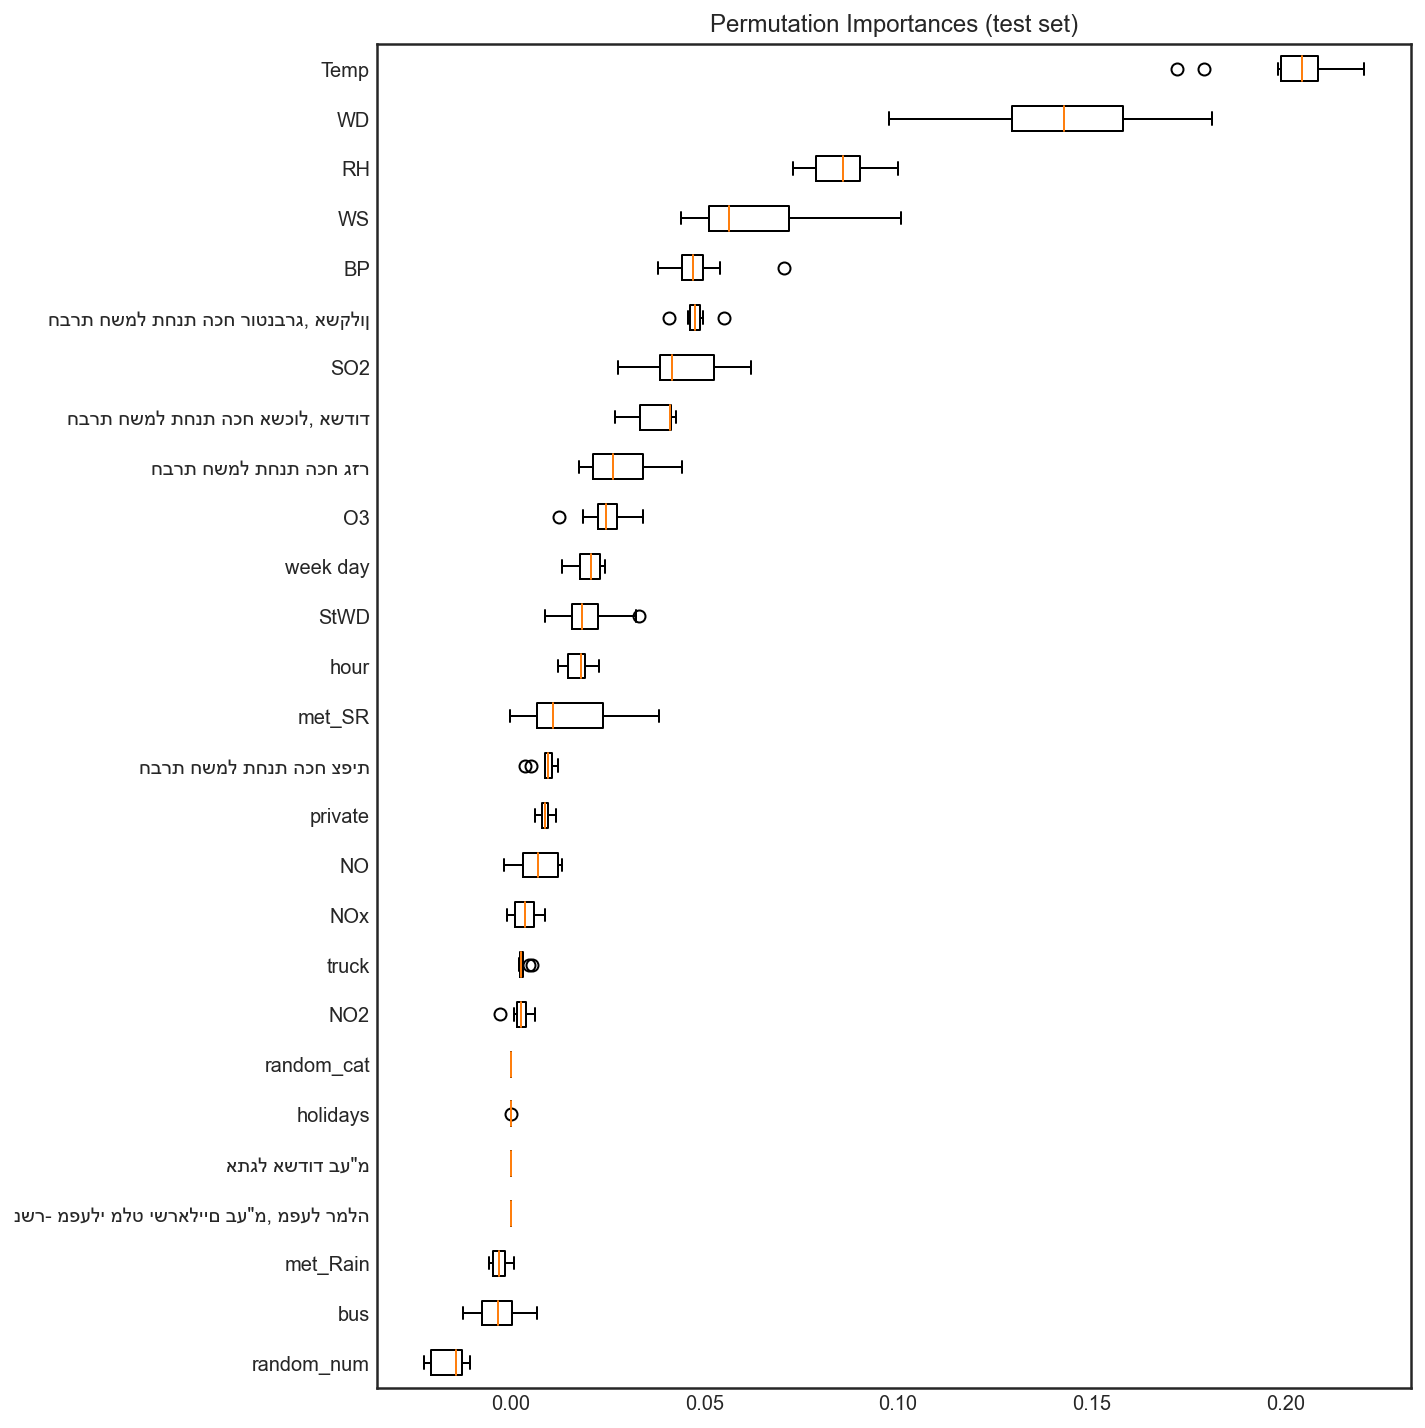

In [1265]:
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
fig, ax = plt.subplots(figsize=(10, 10))
ax.boxplot(perm_importance.importances[sorted_idx].T,
           vert=False, labels=np.array(dtrain.feature_names)[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show();

#### WHEN FA is done on all years

#### Interestingly, I can get feature importances with MLPRegressor using ELI5?
https://datascience.stackexchange.com/questions/44700/how-do-i-get-the-feature-importace-for-a-mlpclassifier

# ADD ATMOSPHERIC STABILITY + SOLAR RADIATION FROM ERA-5 (TIME ISSUES?)